In [1]:
#!source /usr/local/Ascend/ascend-toolkit/set_env.sh
import torch

import torch.nn as nn
import math
from functools import partial
from esm.modules import ContactPredictionHead, ESM1bLayerNorm, RobertaLMHead, TransformerLayer, MultiheadAttention 
import esm
from typing import Union

In [2]:

# print(f"Number of NPU devices: {torch.npu.device_count()}")
# print(f"Current NPU device index: {torch.npu.current_device()}")
# print(f"NPU device name: {torch.npu.get_device_name(torch.npu.current_device())}")

In [3]:
class GroundingAttention(nn.Module):
    def __init__(self, dim, num_heads=4, qkv_bias=True,
                 attn_drop=0., proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim**-0.5

        self.kv = nn.Linear(dim, dim*2, bias=qkv_bias)
        self.q = nn.Linear(dim, dim, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        # self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x, r):
        B, N, C = x.shape
        B_, N_, C_ = r.shape

        kv = self.kv(r).reshape(B_, N_, 2, self.num_heads, C_ //
                                self.num_heads).permute(2, 0, 3, 1, 4)
        k, v = kv.unbind(0)
        q = self.q(x).reshape(B, N, self.num_heads, C //
                              self.num_heads).permute(0, 2, 1, 3)

        attn = (q @ k.transpose(-2, -1)) * self.scale  # (B, heads, N, N_)
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        # x = self.proj(x)
        x = self.proj_drop(x)
        return x

In [4]:
class FFN(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(FFN, self).__init__()
        self.relu = nn.ReLU()
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, input_dim)

    def forward(self, x):
        """
        输入 x 的形状: (batch_size, seq_len, input_dim)
        输出 y 的形状: (batch_size, seq_len, output_dim)
        """
        residual = x
        # x = x.view(-1, x.size(-1))  # 将 x 展平成二维
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        # x = x.view(batch_size, seq_len, -1)  # 将 x 恢复成三维
        x = residual + x
        return x

In [5]:
class bertlayer(nn.Module):
    def __init__(self, embeddingdim, hidden_dim, num_head = 16):
        super(bertlayer, self).__init__()
        self.atte_norm = ESM1bLayerNorm(embeddingdim)
        self.ffn_norm = ESM1bLayerNorm(embeddingdim)
        self.atte = torch.nn.MultiheadAttention(embed_dim = embeddingdim, num_heads = num_head, dropout = 0.0)
        self.ffn = FFN(embeddingdim, hidden_dim)
    def forward(self, x, x_padding_mask):
        residual = x
        x = self.atte_norm(x)
        x, _ = self.atte(x, x, x, key_padding_mask = x_padding_mask)
        x = x + residual
        x = x + self.ffn(self.ffn_norm(x))
        return x



In [6]:
# class InteractionBlock(nn.Module):
#     def __init__(self, embed_dim, ffn_dim, BertLayerNorm = ESM1bLayerNorm, attention_heads = 20, add_bias_kv = True, use_rotary_embeddings = True):
#         super(InteractionBlock, self).__init__()
#         # self.injector_query_norm = norm_layer(embedding_dim)
#         # self.injector_kv_norm = norm_layer(embedding_dim)
#         # self.extractor_query_norm = norm_layer(embedding_dim)
#         # self.extractor_kv_norm = norm_layer(embedding_dim)
#         # self.extractor_norm = norm_layer(embedding_dim)
#         # self.injector = GroundingAttention(embedding_dim)
#         # self.block = GroundingAttention(embedding_dim)
#         # self.extractor = GroundingAttention(embedding_dim)
#         # self.extractor_ffn = FFN(embedding_dim * ffn_dim, ffn_dim_rate * embedding_dim * ffn_dim)
#         self.attention_heads = attention_heads
#         self.embed_dim = embed_dim
#         self.ffn_dim = ffn_dim
#         self.injector_q_norm = BertLayerNorm(embed_dim)
#         self.injector_kv_norm = BertLayerNorm(embed_dim)
#         self.injector = GroundingAttention(embed_dim)
#         self.block = TransformerLayer(
#             self.embed_dim,
#             4 * self.embed_dim, # embed_dim = 1280
#             self.attention_heads, # 20
#             add_bias_kv=False,
#             use_esm1b_layer_norm=True,
#             use_rotary_embeddings=True,
#         )
#         self.extractor_q_norm = BertLayerNorm(embed_dim)
#         self.extractor_kv_norm = BertLayerNorm(embed_dim)
#         self.extractor = GroundingAttention(embed_dim)
#         self.ffn = FFN(embed_dim, ffn_dim)
#     def forward(self, x, r, self_attn_mask=None, self_attn_padding_mask=None, need_head_weights=False):
#         # x = self.injector(self.injector_query_norm(x), self.injector_kv_norm(r)) + x
#         # x = self.block(x, x)
#         # r = self.extractor(self.extractor_query_norm(r), self.extractor_kv_norm(x)) + r
#         # r = r + self.extractor_ffn(self.extractor_norm(r))
#         
#         
#         # x, _ = self.injector_attention(
#         #     query=self.injector_q_norm(x),
#         #     key=self.injector_kv_norm(r),
#         #     value=self.injector_kv_norm(r),
#         #     key_padding_mask=self_attn_padding_mask,
#         #     need_weights=True,
#         #     need_head_weights=need_head_weights,
#         #     attn_mask=self_attn_mask,
#         # )
#         # print(self.injector_q_norm(x).shape)
#         # print(self.injector_q_norm(r).shape)
#         x = x + self.injector(self.injector_q_norm(x),self.injector_kv_norm(r))
#         x, _ = self.block(x,
#                           self_attn_padding_mask=self_attn_padding_mask,
#                           need_head_weights=need_head_weights,
#                           )
#         r = r + self.extractor(self.extractor_q_norm(r),self.extractor_kv_norm(x))
#         r = self.ffn(r)
#         return x, r
class InteractionBlock(nn.Module):
    def __init__(self, embed_dim, ffn_dim, BertLayerNorm = ESM1bLayerNorm, attention_heads = 16, add_bias_kv = True, use_rotary_embeddings = True):
        super(InteractionBlock, self).__init__()
        # self.injector_query_norm = norm_layer(embedding_dim)
        # self.injector_kv_norm = norm_layer(embedding_dim)
        # self.extractor_query_norm = norm_layer(embedding_dim)
        # self.extractor_kv_norm = norm_layer(embedding_dim)
        # self.extractor_norm = norm_layer(embedding_dim)
        # self.injector = GroundingAttention(embedding_dim)
        # self.block = GroundingAttention(embedding_dim)
        # self.extractor = GroundingAttention(embedding_dim)
        # self.extractor_ffn = FFN(embedding_dim * ffn_dim, ffn_dim_rate * embedding_dim * ffn_dim)
        self.attention_heads = attention_heads
        self.embed_dim = embed_dim
        self.ffn_dim = ffn_dim
        self.injector_q_norm = BertLayerNorm(embed_dim)
        self.injector_kv_norm = BertLayerNorm(embed_dim)
        # self.injector = GroundingAttention(embed_dim)

        self.injector = torch.nn.MultiheadAttention(embed_dim = embed_dim, num_heads = attention_heads, dropout = 0.0)
        self.block = bertlayer(embed_dim, embed_dim * 4)
        self.extractor_q_norm = BertLayerNorm(embed_dim)
        self.extractor_kv_norm = BertLayerNorm(embed_dim)
        self.extractor = torch.nn.MultiheadAttention(embed_dim = embed_dim, num_heads = attention_heads, dropout = 0.0)
        self.ffn = FFN(embed_dim, ffn_dim)
    def forward(self, x, r, x_attn_padding_mask=None, r_attn_padding_mask = None, need_head_weights=False):
        # x = self.injector(self.injector_query_norm(x), self.injector_kv_norm(r)) + x
        # x = self.block(x, x)
        # r = self.extractor(self.extractor_query_norm(r), self.extractor_kv_norm(x)) + r
        # r = r + self.extractor_ffn(self.extractor_norm(r))
        
        
        # x, _ = self.injector_attention(
        #     query=self.injector_q_norm(x),
        #     key=self.injector_kv_norm(r),
        #     value=self.injector_kv_norm(r),
        #     key_padding_mask=self_attn_padding_mask,
        #     need_weights=True,
        #     need_head_weights=need_head_weights,
        #     attn_mask=self_attn_mask,
        # )
        # print(self.injector_q_norm(x).shape)
        # print(self.injector_q_norm(r).shape)
        
        
        # x = x + self.injector(self.injector_q_norm(x),self.injector_kv_norm(r))
        residual_x = x
        residual_r = r
        # x = self.injector_q_norm(x)
        # r = self.injector_kv_norm(r)
        x = x.transpose(0, 1)
        r = r.transpose(0, 1)
        x = self.injector_q_norm(x)
        r = self.injector_kv_norm(r)
        # print("r.shape")
        # print(r.shape)
        # print("r_attn_padding_mask.shape")
        # print(r_attn_padding_mask.shape)
        # print("x.shape")
        # print(x.shape)
        x, attn = self.injector(x, r, r, key_padding_mask=r_attn_padding_mask )
        x = x.transpose(0, 1)
        x = x + residual_x
        r = residual_r
        x = x.transpose(0, 1)
        x = self.block(x, x_attn_padding_mask)
        
        # r = r + self.extractor(self.extractor_q_norm(r),self.extractor_kv_norm(x))
        residual_r = r
        residual_x = x.transpose(0, 1)
        # x = self.extractor_kv_norm(x)
        # r = self.extractor_q_norm(r)
        # x = x.transpose(0, 1)
        r = r.transpose(0, 1)
        # print(r.shape)
        # print(x.shape)
        # print(x_attn_padding_mask.shape)
        x = self.extractor_kv_norm(x)
        r = self.extractor_q_norm(r)
        r, attn = self.extractor(r, x, x, key_padding_mask=x_attn_padding_mask)
        r = r.transpose(0, 1)
        r = r + residual_r
        
        r = self.ffn(r)
        return residual_x, r

In [7]:
# class part_test(nn.Module):
#     def __init__(self, embedding_dim, ffn_dim, device, num_layers =36):
#         super(part_test, self).__init__()
#         self.layers = nn.ModuleList()
#         for _ in range(num_layers):
#             block = MultiheadAttention(
#                     embedding_dim,
#                     20,
#                     add_bias_kv=False,
#                     add_zero_attn=False,
#                     use_rotary_embeddings=False,
#                     encoder_decoder_attention=True
#                 )
#             self.layers.append(block)
#     def forward(self, x, x_attn_padding_mask):
#         for layer in self.layers:
#             x, attn = layer(
#                 query=x,
#                 key=x,
#                 value=x,
#                 key_padding_mask=x_attn_padding_mask, #【[fffffttttt]】之类的
#                 need_weights=False,
#                 need_head_weights=False,# false
#                 attn_mask=None, # None
#             )
#         return x
# device = torch.device('npu:0')
# modelb = part_test(1280, 1280  * 4,device)
# X = torch.randn(30,15,1280)
# x_attn_padding_mask = torch.zeros(15,30, dtype=torch.bool)
# X = X.to(device)
# x_attn_padding_mask = x_attn_padding_mask.to(device)
# modelb.to(device)
# opt = torch.optim.Adam(modelb.parameters(), lr=0.00001)
# nuuu = 500000
# for i in range(nuuu):
#     x= modelb(X, x_attn_padding_mask)
#     y = x.sum()
#     y.backward()
#     opt.step()
#     # print(y)
#     if i ==2:
#         print("start")
#     if i ==nuuu - 1:
#         print("done")

In [8]:
# embedding_dim = 1280
# modelb = TransformerLayer(
#                 embedding_dim,
#                 embedding_dim *4, # embed_dim = 1280
#                 20, # 20
#                 add_bias_kv=False,
#                 use_esm1b_layer_norm=True,
#                 use_rotary_embeddings=False,
#             )
# X = torch.randn(50,15,embedding_dim)
# x_attn_padding_mask = torch.zeros(15,50, dtype=torch.bool)
# X = X.to(device)
# x_attn_padding_mask = x_attn_padding_mask.to(device)
# modelb.to(device)
# opt = torch_npu.optim.NpuFusedAdamW(modelb.parameters(), lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=1e-2, amsgrad=False)
# nuuu = 5000
# for i in range(nuuu):
#     x, _ = modelb(X,
#         self_attn_padding_mask=x_attn_padding_mask,
#         need_head_weights=False,
#     )
#     y = x.sum()
#     y.backward()
#     opt.step()
#     # print(y)
#     if i ==2:
#         print("start")
#     if i ==nuuu - 1:
#         print("done")

In [9]:
import esm
class DynamicFeatureSelector(nn.Module):
    def __init__(self, input_size, num_features, num_layers=4):
        super(DynamicFeatureSelector, self).__init__()
        
        # 自动计算每层的节点数量
        self.hidden_layers = []
        self.batch_norm_layers = []  # 用于存储 BatchNorm 层
        current_size = input_size
        decrement = (input_size - num_features) // num_layers  # 递减的步长

        # 添加隐藏层和 BatchNorm 层
        for _ in range(num_layers):
            if current_size <= num_features:
                break
            next_size = max(current_size - decrement, num_features)
            self.hidden_layers.append(nn.Linear(current_size, next_size))
            self.batch_norm_layers.append(nn.BatchNorm1d(next_size))  # 添加 BatchNorm 层
            current_size = next_size

        # 将隐藏层和 BatchNorm 层转换为 ModuleList
        self.hidden_layers = nn.ModuleList(self.hidden_layers)
        self.batch_norm_layers = nn.ModuleList(self.batch_norm_layers)
        self.output_layer = nn.Linear(current_size, num_features)  # 输出层

    def forward(self, x):
        for layer, batch_norm in zip(self.hidden_layers, self.batch_norm_layers):
            x = layer(x)  # 前向传播
            x = batch_norm(x)  # 归一化
            x = torch.relu(x)  # 激活函数
        x = self.output_layer(x)
        return x

class mpi_adapter(nn.Module):
    def __init__(self, embedding_dim, ffn_dim, device, num_layers =39):
        super(mpi_adapter, self).__init__()
        # self.embedding = nn.Embedding(num_embeddings=22, embedding_dim=embedding_dim)
        # self.par_position = PositionalEncoding(num_hiddens=embedding_dim, max_len = par_len)
        # self.mut_position = PositionalEncoding(num_hiddens=embedding_dim, max_len = mut_len)
        # self.mut_esm, _ = esm.pretrained.esm2_t33_650M_UR50D()
        # _, self.alphabet = esm.pretrained.esm2_t33_650M_UR50D()
        # self.padding_idx = self.alphabet.padding_idx
        self.device = device
        # self.esm.to(self.device)
        # self.esm.eval()
        self.liner_mut = nn.Linear(1280,embedding_dim)
        self.liner_par = nn.Linear(1280,embedding_dim)
        # self.batch_converter = self.alphabet.get_batch_converter()
        self.layers = nn.ModuleList()
        for _ in range(num_layers):
            self.layers.append(InteractionBlock(embedding_dim, ffn_dim))
    def forward(self, mut0, mut1, par, mut0_padding_mask, par_padding_mask):
        # print([(str(0), sequence) for sequence in mut0s])
        # print([(str(0), sequence) for sequence in mut1s])
        # print([(str(0), sequence) for sequence in pars])
        # _, _, mut0 = self.batch_converter([(str(0), sequence) for sequence in mut0s])
        # _, _, mut1 = self.batch_converter([(str(0), sequence) for sequence in mut1s])
        # _, _, par = self.batch_converter([(str(0), sequence) for sequence in pars])
        # print(par)
        # mut0 = mut0s.to(self.device)
        # mut1 = mut1s.to(self.device)
        # par = pars.to(self.device)
        # mut0_padding_mask = mut0_padding_mask.to(self.device)
        # par_padding_mask = par_padding_mask.to(self.device)
        # mut0_padding_mask = mut0.eq(self.padding_idx)
        # mut1_padding_mask = mut1.eq(self.padding_idx)
        # par_padding_mask = par.eq(self.padding_idx)
        # mut0_padding_mask = torch.cat((mut0_padding_mask,mut1_padding_mask),dim=1)
        mut0 = torch.cat((mut0,mut1),dim=1)
        mut0 = self.liner_mut(mut0)
        par = self.liner_par(par)
        for layer in self.layers:
            mut0, par = layer(mut0, par, x_attn_padding_mask = mut0_padding_mask, r_attn_padding_mask = par_padding_mask)
        return par
    
# device = torch.device('npu:0')
# # modelb =  TransformerLayer(
# #             1280,
# #             4000, # embed_dim = 1280
# #             20, # 20
# #             add_bias_kv=False,
# #             use_esm1b_layer_norm=True,
# #             use_rotary_embeddings=False,
# #         )
# modelb = mpi_adapter(1280*3, 1280 * 3 * 4,device)
# X = torch.randn(10,15,1280)
# X2 = torch.randn(10,15,1280)
# R = torch.randn(10,100,1280)
# x_attn_padding_mask = torch.zeros(10,30, dtype=torch.bool)
# R_attn_padding_mask = torch.zeros(10,100, dtype=torch.bool)
# X = X.to(device)
# X2 = X2.to(device)
# R = R.to(device)
# x_attn_padding_mask = x_attn_padding_mask.to(device)
# R_attn_padding_mask = R_attn_padding_mask.to(device)
# modelb.to(device)
# opt = torch.optim.Adam(modelb.parameters(), lr=0.00001)
# nuuu = 500000
# for i in range(nuuu):
#     x= modelb(X, X2, R, x_attn_padding_mask, R_attn_padding_mask)
#     y = x.sum()
#     y.backward()
#     opt.step()
#     # print(y)
#     if i ==2:
#         print("start")
#     if i ==nuuu - 1:
#         print("done")


In [10]:
# for layer in modelb.layers:
#     print(next(layer.parameters()).device)


In [11]:
# embedding_dim = 1280*4
# batch_size = 400
# modelb = InteractionBlock(embedding_dim, embedding_dim * 4)
# X = torch.randn(batch_size ,30,embedding_dim)
# # X2 = torch.randn(batch_size ,15,embedding_dim)
# R = torch.randn(batch_size ,100,embedding_dim)
# x_attn_padding_mask = torch.zeros(batch_size ,30, dtype=torch.bool)
# R_attn_padding_mask = torch.zeros(batch_size ,100, dtype=torch.bool)
# X = X.to(device)
# # X2 = X2.to(device)
# R = R.to(device)
# x_attn_padding_mask = x_attn_padding_mask.to(device)
# R_attn_padding_mask = R_attn_padding_mask.to(device)
# modelb.to(device)
# opt = torch.optim.Adam(modelb.parameters(), lr=0.00001)
# nuuu = 500000
# for i in range(nuuu):
#     x , _= modelb(X, R, x_attn_padding_mask, R_attn_padding_mask)
#     y = x.sum()
#     y.backward()
#     opt.step()
#     if i ==2:
#         print("start")
#     if i ==nuuu - 1:
#         print("done")

In [12]:
class MLP_head(nn.Module):
    def __init__(self, embedding_dim, num_layers = 2):
        super(MLP_head, self).__init__()
        self.layers = nn.ModuleList()
        for _ in range(num_layers):
            self.layers.append(GroundingAttention(embedding_dim))
    def forward(self, x):
        for layer in self.layers:
            x = layer(x, x)
        return x[:, 0, :]

In [13]:
class MLP_head_one_layer(nn.Module):
    def __init__(self, embedding_dim, device, num_layers = 1,attention_heads = 16):
        super(MLP_head_one_layer, self).__init__()
        self.layers = nn.ModuleList()
        self.device = device
        self.attention = torch.nn.MultiheadAttention(embed_dim = embedding_dim, num_heads = attention_heads, dropout = 0.0)
        # for _ in range(num_layers):
        #     self.layers.append(TransformerLayer(
        #         embedding_dim,
        #         4 * embedding_dim, # embed_dim = 1280
        #         attention_heads, # 20
        #         add_bias_kv=False,
        #         use_esm1b_layer_norm=True,
        #         use_rotary_embeddings=True,
        #         ))
    def forward(self, x, x_attn_padding_mask, need_head_weights=False):
        x_attn_padding_mask = x_attn_padding_mask.to(self.device)
        result = x[:, 0:1, :]
        x = x.transpose(0, 1)
        result = result.transpose(0, 1)
        result, attn = self.attention(result, x, x, key_padding_mask = x_attn_padding_mask)
        # for layer in self.layers:
        #     x = x.transpose(0, 1)
        #     x, _ = layer(x,
        #                 self_attn_padding_mask=x_attn_padding_mask,
        #                 need_head_weights=need_head_weights,
        #                 )
        #     x = x.transpose(0, 1)
        result = result.transpose(0, 1)
        result = result.squeeze(1)
        return result

In [14]:
#bert中的带权交叉熵顺势函数
class cross_entropy_bert(nn.Module):
    def __init__(self, device):
        super(cross_entropy_bert, self).__init__()
        # self.liner = nn.Linear(embedding_dim, 4)
        self.activate = nn.Sigmoid()
        self.device = device
    def forward(self, b_labels, outputs, weights):
        # weights = weights
        # outputs = self.liner(outputs)
        # print("output:")
        # print(outputs)
        # outputs = self.activate(outputs)
        labels = []
        for index, fue in enumerate(b_labels):
            labels.append(fue)
        loss_sum = torch.tensor(0)
        for i in range(outputs.shape[0]):
            back_part = torch.tensor(0).to(device)
            for j in outputs[i]:
                back_part = back_part + torch.exp(j).to(device)
            back_part = torch.log(back_part).to(device)
            loss_sum = weights[labels[i]] * ((-1) * outputs[i][labels[i]] + back_part)
        loss_sum = loss_sum/outputs.shape[0]
        return loss_sum


In [15]:
import torch
import torch.nn as nn

class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, in_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels, in_channels, kernel_size=3, padding=1)
        # Using average pooling instead
        self.pool = nn.MaxPool1d(kernel_size=1, stride=1)  # Keep dimensions the same

    def forward(self, x):
        identity = x  # Save input for the skip connection
        out = self.conv1(x)
        out = nn.ReLU()(out)
        out = self.conv2(out)
        out = nn.ReLU()(out)
        out = self.pool(out)  # Apply pooling, maintaining dimensions
        out += identity  # Skip connection
        return out

class ResidualModel(nn.Module):
    def __init__(self, input_dim):
        super(ResidualModel, self).__init__()
        self.residual_block1 = ResidualBlock(input_dim)
        self.residual_block2 = ResidualBlock(input_dim)

    def forward(self, x):
        x = self.residual_block1(x)
        x = self.residual_block2(x)
        return x 

class Conv1DGlobalAveragePoolingModel(nn.Module):
    def __init__(self, embedding_dim):
        super(Conv1DGlobalAveragePoolingModel, self).__init__()
        self.conv1d = nn.Conv1d(embedding_dim, embedding_dim, kernel_size=3, padding=1)  # 使用现成的卷积层
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)  # 全局平均池化

    def forward(self, x):
        # x 的形状为 (batch_size, length, embedding_dim)
        x = x.transpose(1, 2)  # 调整维度为 (batch_size, embedding_dim, length)
        x = self.conv1d(x)  # 经过一维卷积层
        x = self.global_avg_pool(x)  # 经过全局平均池化
        return x  # 输出的形状为 (batch_size, embedding_dim, 1)


class mippi_one(nn.Module):
    def __init__(self, embedding_dim, ffn_dim, device, num_layers =3):
        super(mippi_one, self).__init__()
        # self.embedding = nn.Embedding(num_embeddings=22, embedding_dim=embedding_dim)
        # self.par_position = PositionalEncoding(num_hiddens=embedding_dim, max_len = par_len)
        # self.mut_position = PositionalEncoding(num_hiddens=embedding_dim, max_len = mut_len)
        # self.mut_esm, _ = esm.pretrained.esm2_t33_650M_UR50D()
        # _, self.alphabet = esm.pretrained.esm2_t33_650M_UR50D()
        # self.padding_idx = self.alphabet.padding_idx
        self.device = device
        # self.esm.to(self.device)
        # self.esm.eval()
        self.liner_mut = nn.Linear(1280,embedding_dim)
        self.liner_par = nn.Linear(1280,embedding_dim)
        # self.batch_converter = self.alphabet.get_batch_converter()
        self.layersa = nn.ModuleList()
        self.layersb = nn.ModuleList()
        for _ in range(3):
            self.layersa.append(bertlayer(embedding_dim, embedding_dim * 4))
            self.layersa.append(bertlayer(embedding_dim, embedding_dim * 4))
        self.conv1 = ResidualModel(embedding_dim)
        self.conv2 = ResidualModel(embedding_dim)
        self.conv3 = ResidualModel(embedding_dim)
        self.conv4 = ResidualModel(embedding_dim)
        self.pooling = Conv1DGlobalAveragePoolingModel(embedding_dim)

    def forward(self, mut0, mut1, par, mut0_padding_mask, mut1_padding_mask, par_padding_mask):
        # print([(str(0), sequence) for sequence in mut0s])
        # print([(str(0), sequence) for sequence in mut1s])
        # print([(str(0), sequence) for sequence in pars])
        # _, _, mut0 = self.batch_converter([(str(0), sequence) for sequence in mut0s])
        # _, _, mut1 = self.batch_converter([(str(0), sequence) for sequence in mut1s])
        # _, _, par = self.batch_converter([(str(0), sequence) for sequence in pars])
        # print(par)
        # mut0 = mut0s.to(self.device)
        # mut1 = mut1s.to(self.device)
        # par = pars.to(self.device)
        # mut0_padding_mask = mut0_padding_mask.to(self.device)
        # par_padding_mask = par_padding_mask.to(self.device)
        # mut0_padding_mask = mut0.eq(self.padding_idx)
        # mut1_padding_mask = mut1.eq(self.padding_idx)
        # par_padding_mask = par.eq(self.padding_idx)
        # mut0_padding_mask = torch.cat((mut0_padding_mask,mut1_padding_mask),dim=1)
        # mut0 = torch.cat((mut0,mut1),dim=1)
        mut0 = self.liner_mut(mut0)
        mut1 = self.liner_mut(mut1)
        par = self.liner_par(par)
        mut0 = mut0.transpose(0,1)
        mut1 = mut1.transpose(0,1)
        par = par.transpose(0,1)
        for layer in self.layersa:
            mut0 = layer(mut0, mut0_padding_mask)
            mut1 = layer(mut1, mut1_padding_mask)
        for layer in self.layersb:
            par = layer(par, par_padding_mask)
        mut0 = mut0.transpose(0,1)
        mut1 = mut1.transpose(0,1)
        par = par.transpose(0,1)
        mut0 = mut0.transpose(2,1)
        mut1 = mut1.transpose(2,1)
        par = par.transpose(2,1)
        mut0 = self.conv1(mut0)
        mut1 = self.conv1(mut1)
        par = self.conv2(par)
        par = self.conv3(par)
        mut0 = mut0.transpose(2,1)
        mut1 = mut1.transpose(2,1)
        par = par.transpose(2,1)
        par = torch.cat((mut0 / mut1, mut0 - mut1, par, mut0, mut1), dim = 1)
        return self.pooling(par).squeeze(2)

In [16]:
class Sum_model(nn.Module):
    def __init__(self, device, embedding_dim = 192,):
        super(Sum_model, self).__init__()
        self.device = device
        self.result = nn.Parameter(torch.randn(1280))
        self.backbone = mippi_one(embedding_dim, embedding_dim*4,device)
        # self.neck = MLP_head_one_layer(embedding_dim, device)
        # self.head = cross_entropy_bert(embedding_dim, device)
        self.head = nn.Linear(embedding_dim, 4)
    def forward(self,  mut0s, mut1s, pars, mut0_padding_mask, mut1_padding_mask, par_padding_mask, weight, label):
        res = self.result.repeat(pars.shape[0], 1).unsqueeze(1) 
        pars = torch.concat([res,pars], dim = 1)
        false_column = torch.zeros(par_padding_mask.size(0), 1, dtype=torch.bool).to(self.device)
        # 在第一列前添加一排 False
        par_padding_mask = torch.cat((false_column, par_padding_mask), dim=1)
        x = self.backbone(mut0s, mut1s, pars, mut0_padding_mask, mut1_padding_mask, par_padding_mask)
        # print("x1:")
        # x = self.neck(pars, par_padding_mask)
        # x = self.neck(x, par_padding_mask)
        # print("x2")
        # print(x)
        # x = self.head(label, x, weight)
        x = self.head(x)
        return x

In [17]:
class PandasDataReader:
    def __init__(self, df, batch_size=1, shuffle=False):
        self.df = df.sample(frac=1).reset_index(drop=True) if shuffle else df
        self.batch_size = batch_size
        self.current_index = 0

    def __iter__(self):
        return self

    def __next__(self):
        if self.current_index >= len(self.df):
            raise StopIteration()

        batch = self.df.iloc[self.current_index:self.current_index+self.batch_size]
        self.current_index += self.batch_size

        # 如果 batch_size 为 1, 则直接返回 batch 的第一行
        return batch.iloc[0] if self.batch_size == 1 else batch
# data_reader = PandasDataReader(df, batch_size=7, shuffle=True)

In [18]:
class ESMModelWrapper(nn.Module):
    def __init__(self, model):
        super(ESMModelWrapper, self).__init__()
        self.model = model

    def forward(self, batch_tokens, repr_layers=[33], return_contacts=False):
        return self.model(batch_tokens, repr_layers=repr_layers, return_contacts=return_contacts)


class ESMFeatureEncoder(nn.Module):
    def __init__(self):
        super(ESMFeatureEncoder, self).__init__()
        self.device = 'cuda:3'
        self.model, self.alphabet = esm.pretrained.esm2_t33_650M_UR50D()
        self.model.to(self.device)
        self.model.eval()  # Set the model to evaluation mode
        self.batch_converter = self.alphabet.get_batch_converter()
        self.padding_idx = self.alphabet.padding_idx
        # Wrap the model with the ESMModelWrapper
        self.model = ESMModelWrapper(self.model)

    def encode(self, sequences):
        batch_labels, batch_strs, batch_tokens = self.batch_converter([(str(0), sequence) for sequence in sequences])
        batch_tokens = batch_tokens.to(self.device)
        batch_mask = batch_tokens.eq(self.padding_idx)
        # print(batch_tokens.shape)
        with torch.no_grad():
            results = self.model(batch_tokens, repr_layers=[33], return_contacts=False)
        token_representations = results['representations'][33]
        # print(results['representations'][33].mean(dim=1).unsqueeze(1).shape)
        return token_representations,batch_mask

In [19]:
import pandas as pd
data_path = 'mippi/processed_mutations.dataset'
df = pd.read_pickle(data_path)

new_df1 = df[df['label'] == 1].copy()
new_df1['mut0'], new_df1['mut1'] = new_df1['mut1'], new_df1['mut0']
new_df1['label'] = 3
new_df2 = df[df['label'] == 3].copy()
new_df2['mut0'], new_df2['mut1'] = new_df2['mut1'], new_df2['mut0']
new_df2['label'] = 1

new_df3 = df[df['label'] == 2].copy()
new_df3['mut0'], new_df3['mut1'] = new_df3['mut1'], new_df3['mut0']
new_df3['label'] = 2
df = pd.concat([df, new_df2, new_df1, new_df3], ignore_index=True)
df["position_total"] = df["Feature range(s)"].apply(
    lambda x: sorted(set([int(y.split("-")[0]) for y in x] + [int(y.split("-")[1]) for y in x]))
)
df["position"] = df["position_total"].apply(lambda x: math.ceil((min(x) + max(x)) / 2))
print(df.shape)
df.head()

(38706, 26)


,#Feature AC,Feature range(s),Original sequence,Resulting sequence,Feature short label,Feature type,Feature annotation,Affected protein AC,Affected protein symbol,Affected protein full name,...,n_partner,mutAC,mut0,parAC,par0,mut1,label,mutAC1,position_total,position
0,EBI-10039489,[81-81],[V],[E],p.Val81Glu,mutation disrupting(MI:0573),,P28795,PEX3,,...,2,P28795,MAPNQRSRSLLQRHRGKVLISLTGIAALFTTGSVVVFFVKRWLYKQ...,Q03694,MVLSRGETKKNSVRLTAKQEKKPQSTFQTLKQSLKLSNNKKLKQDS...,MAPNQRSRSLLQRHRGKVLISLTGIAALFTTGSVVVFFVKRWLYKQ...,0,P28795_Val81Glu,[81],81
1,EBI-10039495,[188-188],[N],[I],p.Asn188Ile,mutation decreasing(MI:0119),,P28795,PEX3,,...,2,P28795,MAPNQRSRSLLQRHRGKVLISLTGIAALFTTGSVVVFFVKRWLYKQ...,Q03694,MVLSRGETKKNSVRLTAKQEKKPQSTFQTLKQSLKLSNNKKLKQDS...,MAPNQRSRSLLQRHRGKVLISLTGIAALFTTGSVVVFFVKRWLYKQ...,1,P28795_Asn188Ile,[188],188
2,EBI-10039551,[81-81],[V],[E],p.Val81Glu,mutation disrupting(MI:0573),,P28795,PEX3,,...,2,P28795,MAPNQRSRSLLQRHRGKVLISLTGIAALFTTGSVVVFFVKRWLYKQ...,Q03694,MVLSRGETKKNSVRLTAKQEKKPQSTFQTLKQSLKLSNNKKLKQDS...,MAPNQRSRSLLQRHRGKVLISLTGIAALFTTGSVVVFFVKRWLYKQ...,0,P28795_Val81Glu,[81],81
3,EBI-10039706,[81-81],[V],[E],p.Val81Glu,mutation disrupting(MI:0573),,P28795,PEX3,,...,2,P28795,MAPNQRSRSLLQRHRGKVLISLTGIAALFTTGSVVVFFVKRWLYKQ...,Q03694,MVLSRGETKKNSVRLTAKQEKKPQSTFQTLKQSLKLSNNKKLKQDS...,MAPNQRSRSLLQRHRGKVLISLTGIAALFTTGSVVVFFVKRWLYKQ...,0,P28795_Val81Glu,[81],81
4,EBI-10039722,[81-81],[V],[E],p.Val81Glu,mutation disrupting(MI:0573),,P28795,PEX3,,...,2,P28795,MAPNQRSRSLLQRHRGKVLISLTGIAALFTTGSVVVFFVKRWLYKQ...,Q03694,MVLSRGETKKNSVRLTAKQEKKPQSTFQTLKQSLKLSNNKKLKQDS...,MAPNQRSRSLLQRHRGKVLISLTGIAALFTTGSVVVFFVKRWLYKQ...,0,P28795_Val81Glu,[81],81


In [ ]:
len_half_protein_used =10 
# seq_lengths = df['Original sequence'].apply(lambda x: len(x[0]))
# # 选择唯一元素长度小于等于 10 的行
# df_filtered = df.loc[seq_lengths <= len_half_protein_used]
# seq_lengths = df['Resulting sequence'].apply(lambda x: len(x[0]))
# # 选择唯一元素长度小于等于 10 的行
# df_filtered = df.loc[seq_lengths <= len_half_protein_used]
df = df[df["position_total"].apply(lambda x: max(x) - min(x) < 2* len_half_protein_used)]
df.shape

(37276, 26)

In [21]:
df = df[df['mut0'].str.len() <= 1000]
df = df[df['par0'].str.len() <= 1000]
df = df[df['label'] != 4]
df.shape

(29082, 26)

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class GHMC_Loss(nn.Module):
    def __init__(self, device, bins=8, momentum=0.3):
        super(GHMC_Loss, self).__init__()
        self.device = device
        self.bins = bins
        self.momentum = momentum
        self.edges = [float(x) / self.bins for x in range(self.bins + 1)]
        if momentum > 0:
            self.acc_sum = np.zeros(bins)

    def forward(self, targets, logits, no_meaning):
        targets = torch.tensor(targets.to_list())
        targets = F.one_hot(targets, num_classes=4).float().to(self.device)
        # Calculate gradient norm
        edges = self.edges
        mmt = self.momentum
        weights = torch.zeros_like(logits)
        g = torch.abs(logits.softmax(dim=1).detach().to(self.device) - targets.to(self.device))

        tot = logits.shape[0] * logits.shape[1]  # Total number of elements
        n = 0  # n valid bins
        for i in range(self.bins):
            inds = (g >= edges[i]) & (g < edges[i + 1])
            num_in_bin = inds.sum().item()
            if num_in_bin > 0:
                if mmt > 0:
                    self.acc_sum[i] = mmt * self.acc_sum[i] + (1 - mmt) * num_in_bin
                    weights[inds] = tot / self.acc_sum[i]
                else:
                    weights[inds] = tot / num_in_bin
                n += 1
        if n > 0:
            weights = weights / n

        # Flatten targets to match logits shape
        targets = targets.argmax(dim=1)

        # Calculate the loss
        loss = F.cross_entropy(logits, targets, reduction='none')

        # Apply weights to the loss
        weights = weights.max(dim=1)[0]  # Get the maximum weight for each sample
        loss = (loss * weights).sum() / tot

        return loss

In [23]:
def positional_encoding(max_len, d_model):
    # 创建位置编码矩阵
    position = torch.arange(max_len, dtype=torch.float).unsqueeze(1)  # 形状为 (max_len, 1)
    div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(np.log(10000.0) / d_model))  # 计算分母
    
    # 计算位置编码
    pe = torch.zeros(max_len, d_model)  # 初始化位置编码矩阵
    pe[:, 0::2] = torch.sin(position * div_term)  # 偶数维度
    pe[:, 1::2] = torch.cos(position * div_term)  # 奇数维度
    pe.requires_grad = False
    return pe



In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from IPython.display import clear_output
from sklearn.metrics import accuracy_score
import json
batch_size = 4
# 五折交叉验证
splits = 10
# Create StratifiedKFold object.
# 创建StratifiedKFold对象    StratifiedKFold是sklearn库中的一个类，用于将数据集进行分层抽样设置了4个分割（n_splits=splits），打乱数据顺序（shuffle=True）并设置随机种子（random_state=1）。
skf = StratifiedKFold(n_splits=splits, shuffle=True)# , random_state=1
# device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
device = torch.device('cuda:3')
# 定义优化器
model = Sum_model(device)
model.load_state_dict(torch.load('model_params_mirror2.pth'))
print(f"Using device: {device}")
model.to(device)
model_loss = GHMC_Loss(device)
esm_model = ESMFeatureEncoder()
optimizer = torch.optim.AdamW(model.parameters(), lr=4e-6, betas=(0.9, 0.999), weight_decay=1e-6, amsgrad=False)
# optimizer = torch.optim.Adam(model.parameters(), lr=6e-5)
# for train_index, test_index in skf.split(df,df["label"]):#它接受两个参数：x 和 y，分别表示特征数据和目标数据
#     x_train_fold, x_test_fold = df.iloc[train_index], df.iloc[test_index]#iloc是pandas库中的一个属性，用于基于整数位置的索引
    # y_train_fold, y_test_fold = df["label"].iloc[train_index], df["label"].iloc[test_index]
x_train_fold = pd.read_csv('data/x_train_fold_mirror2.csv')
x_test_fold = pd.read_csv('data/x_test_fold_mirror2.csv')
class_weights = compute_class_weight(class_weight='balanced',classes=np.unique(x_train_fold['label']),y=np.ravel(x_train_fold["label"]))
# print(class_weights)
# class_weights_list.append(class_weights)
batch_size = 7
optimizer.zero_grad()
loss_range = []
acc_test = []
acc_train = []
position_embedding = positional_encoding(2 * len_half_protein_used + 2 , 1280).to(device)
for epoc in range(40):
    label_need_train = []
    label_pred_train = []
    label_need = []
    label_pred = []
    i = 0
    loss_onebatch = 0
    x_train_fold = x_train_fold.sample(frac=1).reset_index(drop=True)
    data_reader = PandasDataReader(x_train_fold, batch_size=batch_size, shuffle=True)
    num_epochs = len(x_train_fold)
    for batch in data_reader:
        if False:
            loss = model([batch["mut0"]],[ batch["mut1"]], [batch["par0"]], [max(int(batch["Feature range(s)"][0].split("-")[0])-25,0),max(int(batch["Feature range(s)"][0].split("-")[0])-25,0)+50],class_weights,[batch["label"]],device) # 三个序列和需要的突变采样位置，如突变从80号开始就是[80-25，80+25]
            loss_onebatch = loss_onebatch + loss.item()
        else:
            positions = batch["position"].tolist()
            # print([sequence for sequence in batch["mut0"]][0])
            mut0,mut0_mask = esm_model.encode([sequence for sequence in batch["mut0"]])
            mut1,mut1_mask = esm_model.encode([sequence for sequence in batch["mut1"]])
            par0,par0_mask = esm_model.encode([sequence for sequence in batch["par0"]])
            # #类似位置编码，标记突变前后的
            # zero_row = torch.zeros(mut0.shape[0], mut0.shape[1], 1).to(device)
            # mut0 = torch.cat((mut0, zero_row), dim=-1)
            # zero_row = torch.ones(mut1.shape[0], mut1.shape[1], 1).to(device)
            # mut1 = torch.cat((mut1, zero_row), dim=-1)
            #处理mut0，mut1，去除0，找到位置，接入全局变量，01拼接在模型里
            # mut0 = mut0[:, 1:, :]
            if mut0.shape[1] < 2*len_half_protein_used:
                mut0 = torch.cat((mut0.mean(dim=1, keepdim=True),mut0),dim=1)
                mut0_mask = mut0_mask
                mut1 = torch.cat((mut1.mean(dim=1, keepdim=True),mut1),dim=1)
                mut1_mask = mut1_mask
            else:
                result = torch.randn(mut0.shape[0],2*len_half_protein_used,mut0.shape[2])
                result_padding = (np.random.randint(0, 2, size=(mut0.shape[0], 2*len_half_protein_used)) == 1)

                for ia in range(len(positions)):
                    position = int(positions[ia])
                    if position - len_half_protein_used < 0 :
                        result[ia, :, :] = mut0[ia,:2 * len_half_protein_used,:]
                        result_padding[ia, :] = mut0_mask[ia,:2 * len_half_protein_used].cpu()
                    elif position + len_half_protein_used > mut0.shape[1] :
                        result[ia, :, :] = mut0[ia,-2 * len_half_protein_used:,:]
                        result_padding[ia, :] = mut0_mask[ia, -2 * len_half_protein_used].cpu()
                    else:
                        result[ia, :, :] = mut0[ia,position - len_half_protein_used:position + len_half_protein_used,:]
                        result_padding[ia, :] = mut0_mask[ia, position - len_half_protein_used : position + len_half_protein_used].cpu()

                mut0 = torch.cat((mut0.mean(dim=1, keepdim=True).cpu(), result),dim=1)
                mut0_mask = result_padding
                mut0_mask = np.concatenate([np.full((mut0_mask.shape[0], 1), False), mut0_mask], axis=1)
                
                
                
                result = torch.randn(mut1.shape[0],2*len_half_protein_used,mut1.shape[2])
                result_padding = (np.random.randint(0, 2, size=(mut1.shape[0], 2*len_half_protein_used)) == 1)
                for ia in range(len(positions)):
                    position = int(positions[ia])
                    if position - len_half_protein_used < 0 :
                        result[ia, :, :] = mut1[ia,:2 * len_half_protein_used,:]
                        result_padding[ia, :] = mut1_mask[ia,:2 * len_half_protein_used].cpu()
                    elif position + len_half_protein_used > mut1.shape[1] :
                        result[ia, :, :] = mut1[ia,-2 * len_half_protein_used : ,:]
                        result_padding[ia, :] = mut1_mask[ia, -2 * len_half_protein_used].cpu()
                    else:
                        # print(i)
                        result[ia, :, :] = mut1[ia,position - len_half_protein_used:position + len_half_protein_used,:]
                        result_padding[ia, :] = mut1_mask[ia, position - len_half_protein_used: position + len_half_protein_used].cpu()
                mut1 = torch.cat((mut1.mean(dim=1, keepdim=True).cpu(), result),dim=1)
                mut1_mask = result_padding
                mut1_mask = np.concatenate([np.full((mut1_mask.shape[0], 1), False), mut1_mask], axis=1)
                
                
            mut0_mask = torch.from_numpy(mut0_mask)
            mut0_mask = mut0_mask.to(device)
            mut1_mask = torch.from_numpy(mut1_mask)
            mut1_mask = mut1_mask.to(device)
            mut0 = mut0.to(device)
            mut1 = mut1.to(device)
            mut0 = mut0 + position_embedding[:mut0.shape[1] , : ]
            mut1 = mut1 + position_embedding[2 * len_half_protein_used + 1 : 2 * len_half_protein_used + 1 + mut1.shape[1] , : ]
            par0 = par0.to(device)
            # par0_mask = torch.from_numpy(par0_mask)
            # for position in batch["Feature range(s)"]:
            #     positions.append([max(int(position[0].split("-")[0])-25,0),max(int(position[0].split("-")[0])-25,0)+50])
            out = model(mut0, mut1, par0, mut0_mask, mut1_mask, par0_mask, class_weights, batch["label"])
            loss = model_loss(batch["label"], out,class_weights)
            _, predicted_labels = torch.max(out, 1)
            if torch.isnan(loss):
                break
            # break
            # loss = ghm_loss(out, batch["label"].to_list())
            # loss_onebatch = loss_onebatch + loss.item()
            loss_range.append(loss.item())
            # print(loss.item())
            
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        print("done")
        label_need_train = label_need_train + batch["label"].to_list()
        label_pred_train = label_pred_train + predicted_labels.tolist()
        if (i) % batch_size*20 == 0:
            clear_output()
            print(f' [{i}/{num_epochs}], Loss: {loss}')

        i = i+batch_size
    accuracy = accuracy_score(label_need_train,label_pred_train)
    acc_train.append(accuracy)
    torch.save(model.state_dict(), 'model_params_mirror22.pth')
    model.eval()
    data_reader = PandasDataReader(x_test_fold, batch_size=10, shuffle=True)
    num_epochs = len(x_train_fold)
    print("testing",epoc)
    for batch in data_reader:
        if False:
            loss = model([batch["mut0"]],[ batch["mut1"]], [batch["par0"]], [max(int(batch["Feature range(s)"][0].split("-")[0])-25,0),max(int(batch["Feature range(s)"][0].split("-")[0])-25,0)+50],class_weights,[batch["label"]],device) # 三个序列和需要的突变采样位置，如突变从80号开始就是[80-25，80+25]
            loss_onebatch = loss_onebatch + loss.item()
        else:
            positions = batch["position"].tolist()
            # print([sequence for sequence in batch["mut0"]][0])
            mut0,mut0_mask = esm_model.encode([sequence for sequence in batch["mut0"]])
            mut1,mut1_mask = esm_model.encode([sequence for sequence in batch["mut1"]])
            par0,par0_mask = esm_model.encode([sequence for sequence in batch["par0"]])
            # zero_row = torch.zeros(mut0.shape[0], mut0.shape[1], 1).to(device)
            # mut0 = torch.cat((mut0, zero_row), dim=-1)
            # zero_row = torch.ones(mut1.shape[0], mut1.shape[1], 1).to(device)
            # mut1 = torch.cat((mut1, zero_row), dim=-1)
            #处理mut0，mut1，去除0，找到位置，接入全局变量，01拼接在模型里
            # mut0 = mut0[:, 1:, :]
            if mut0.shape[1] < 2*len_half_protein_used:
                mut0 = torch.cat((mut0.mean(dim=1, keepdim=True),mut0),dim=1)
                mut0_mask = mut0_mask
                mut1 = torch.cat((mut1.mean(dim=1, keepdim=True),mut1),dim=1)
                mut1_mask = mut1_mask
            else:
                result = torch.randn(mut0.shape[0],2*len_half_protein_used,mut0.shape[2])
                result_padding = (np.random.randint(0, 2, size=(mut0.shape[0], 2*len_half_protein_used)) == 1)

                for ia in range(len(positions)):
                    position = int(positions[ia])
                    if position - len_half_protein_used < 0 :
                        result[ia, :, :] = mut0[ia,:2 * len_half_protein_used,:]
                        result_padding[ia, :] = mut0_mask[ia, : 2 * len_half_protein_used].cpu()
                    elif position + len_half_protein_used > mut0.shape[1] :
                        result[ia, :, :] = mut0[ia,-2 * len_half_protein_used:,:]
                        result_padding[ia, :] = mut0_mask[ia, -2 * len_half_protein_used].cpu()
                    else:
                        result[ia, :, :] = mut0[ia,position - len_half_protein_used:position + len_half_protein_used,:]
                        result_padding[ia, :] = mut0_mask[ia, position - len_half_protein_used : position + len_half_protein_used].cpu()

                mut0 = torch.cat((mut0.mean(dim=1, keepdim=True).cpu(), result),dim=1)
                mut0_mask = result_padding
                mut0_mask = np.concatenate([np.full((mut0_mask.shape[0], 1), False), mut0_mask], axis=1)
                
                
                
                result = torch.randn(mut1.shape[0],2*len_half_protein_used,mut1.shape[2])
                result_padding = (np.random.randint(0, 2, size=(mut1.shape[0], 2*len_half_protein_used)) == 1)
                for ia in range(len(positions)):
                    position = int(positions[ia])
                    if position - len_half_protein_used < 0 :
                        result[ia, :, :] = mut1[ia,:2 * len_half_protein_used,:]
                        result_padding[ia, :] = mut1_mask[ia , : 2 * len_half_protein_used].cpu()
                    elif position + len_half_protein_used > mut1.shape[1] :
                        result[ia, :, :] = mut1[ia,-2 * len_half_protein_used : ,:]
                        result_padding[ia, :] = mut1_mask[ia , -2 * len_half_protein_used].cpu()
                    else:
                        # print(i)
                        result[ia, :, :] = mut1[ia,position - len_half_protein_used:position + len_half_protein_used,:]
                        result_padding[ia, :] = mut1_mask[ia, position - len_half_protein_used : position + len_half_protein_used].cpu()
                mut1 = torch.cat((mut1.mean(dim=1, keepdim=True).cpu(), result),dim=1)
                mut1_mask = result_padding
                mut1_mask = np.concatenate([np.full((mut1_mask.shape[0], 1), False), mut1_mask], axis=1)
                
                
            mut0_mask = torch.from_numpy(mut0_mask)
            mut0_mask = mut0_mask.to(device)
            mut1_mask = torch.from_numpy(mut1_mask)
            mut1_mask = mut1_mask.to(device)
            mut0 = mut0.to(device)
            mut1 = mut1.to(device)
            par0 = par0.to(device)
            mut0 = mut0 + position_embedding[:mut0.shape[1] , : ]
            mut1 = mut1 + position_embedding[2 * len_half_protein_used + 1 : 2 * len_half_protein_used + 1 + mut1.shape[1] , : ]
            x = model(mut0, mut1, par0, mut0_mask,mut1_mask, par0_mask, class_weights,batch["label"])
            _, predicted = torch.max(x, 1)
            label_pred = label_pred + predicted.tolist()
            label_need = label_need + batch['label'].to_list()
    accuracy = accuracy_score(label_need, label_pred)
    acc_test.append(accuracy)
    model.train()
    with open('test_result_mirror22.json', 'w') as file:
        json.dump(acc_test, file)
    with open('train_result_mirror22.json', 'w') as file:
        json.dump(acc_train, file)
    with open('label_need_withoutcross2.json', 'w') as file:
        json.dump(label_need, file)
    with open('label_pred_withoutcross2.json', 'w') as file:
        json.dump(label_pred, file)
    if torch.isnan(loss):
        break
    if accuracy > 0.85:
        break

 [987/26174], Loss: 0.33121582865715027


In [ ]:
# from sklearn.model_selection import StratifiedKFold
# from sklearn.utils.class_weight import compute_class_weight
# import numpy as np
# from IPython.display import clear_output
# from sklearn.metrics import accuracy_score
# import json
# batch_size = 4
# # 五折交叉验证
# splits = 10
# # Create StratifiedKFold object.
# # 创建StratifiedKFold对象    StratifiedKFold是sklearn库中的一个类，用于将数据集进行分层抽样设置了4个分割（n_splits=splits），打乱数据顺序（shuffle=True）并设置随机种子（random_state=1）。
# skf = StratifiedKFold(n_splits=splits, shuffle=True)# , random_state=1
# # device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
# device = torch.device('cuda:2')
# # 定义优化器
# model = Sum_model(device)
# print(f"Using device: {device}")
# model.to(device)
# model_loss = GHMC_Loss(device)
# esm_model = ESMFeatureEncoder()
# optimizer = torch.optim.AdamW(model.parameters(), lr=4e-5, betas=(0.9, 0.999), weight_decay=1e-4, amsgrad=False)
# # optimizer = torch.optim.Adam(model.parameters(), lr=6e-5)
# for train_index, test_index in skf.split(df,df["label"]):#它接受两个参数：x 和 y，分别表示特征数据和目标数据
#     x_train_fold, x_test_fold = df.iloc[train_index], df.iloc[test_index]#iloc是pandas库中的一个属性，用于基于整数位置的索引
#     # y_train_fold, y_test_fold = df["label"].iloc[train_index], df["label"].iloc[test_index]
# x_train_fold.to_csv('data/x_train_fold_mirror2.csv')
# x_test_fold.to_csv('data/x_test_fold_mirror2.csv')
# class_weights = compute_class_weight(class_weight='balanced',classes=np.unique(x_train_fold['label']),y=np.ravel(x_train_fold["label"]))
# # print(class_weights)
# # class_weights_list.append(class_weights)
# batch_size = 7
# optimizer.zero_grad()
# loss_range = []
# acc_test = []
# acc_train = []
# position_embedding = positional_encoding(2 * len_half_protein_used + 2 , 1280).to(device)
# for epoc in range(40):
#     label_need_train = []
#     label_pred_train = []
#     label_need = []
#     label_pred = []
#     i = 0
#     loss_onebatch = 0
#     x_train_fold = x_train_fold.sample(frac=1).reset_index(drop=True)
#     data_reader = PandasDataReader(x_train_fold, batch_size=batch_size, shuffle=True)
#     num_epochs = len(x_train_fold)
#     for batch in data_reader:
#         if False:
#             loss = model([batch["mut0"]],[ batch["mut1"]], [batch["par0"]], [max(int(batch["Feature range(s)"][0].split("-")[0])-25,0),max(int(batch["Feature range(s)"][0].split("-")[0])-25,0)+50],class_weights,[batch["label"]],device) # 三个序列和需要的突变采样位置，如突变从80号开始就是[80-25，80+25]
#             loss_onebatch = loss_onebatch + loss.item()
#         else:
#             positions = batch["position"].tolist()
#             # print([sequence for sequence in batch["mut0"]][0])
#             mut0,mut0_mask = esm_model.encode([sequence for sequence in batch["mut0"]])
#             mut1,mut1_mask = esm_model.encode([sequence for sequence in batch["mut1"]])
#             par0,par0_mask = esm_model.encode([sequence for sequence in batch["par0"]])
#             # #类似位置编码，标记突变前后的
#             # zero_row = torch.zeros(mut0.shape[0], mut0.shape[1], 1).to(device)
#             # mut0 = torch.cat((mut0, zero_row), dim=-1)
#             # zero_row = torch.ones(mut1.shape[0], mut1.shape[1], 1).to(device)
#             # mut1 = torch.cat((mut1, zero_row), dim=-1)
#             #处理mut0，mut1，去除0，找到位置，接入全局变量，01拼接在模型里
#             # mut0 = mut0[:, 1:, :]
#             if mut0.shape[1] < 2*len_half_protein_used:
#                 mut0 = torch.cat((mut0.mean(dim=1, keepdim=True),mut0),dim=1)
#                 mut0_mask = mut0_mask
#                 mut1 = torch.cat((mut1.mean(dim=1, keepdim=True),mut1),dim=1)
#                 mut1_mask = mut1_mask
#             else:
#                 result = torch.randn(mut0.shape[0],2*len_half_protein_used,mut0.shape[2])
#                 result_padding = (np.random.randint(0, 2, size=(mut0.shape[0], 2*len_half_protein_used)) == 1)

#                 for ia in range(len(positions)):
#                     position = int(positions[ia])
#                     if position - len_half_protein_used < 0 :
#                         result[ia, :, :] = mut0[ia,:2 * len_half_protein_used,:]
#                         result_padding[ia, :] = mut0_mask[ia,:2 * len_half_protein_used].cpu()
#                     elif position + len_half_protein_used > mut0.shape[1] :
#                         result[ia, :, :] = mut0[ia,-2 * len_half_protein_used:,:]
#                         result_padding[ia, :] = mut0_mask[ia, -2 * len_half_protein_used].cpu()
#                     else:
#                         result[ia, :, :] = mut0[ia,position - len_half_protein_used:position + len_half_protein_used,:]
#                         result_padding[ia, :] = mut0_mask[ia, position - len_half_protein_used : position + len_half_protein_used].cpu()

#                 mut0 = torch.cat((mut0.mean(dim=1, keepdim=True).cpu(), result),dim=1)
#                 mut0_mask = result_padding
#                 mut0_mask = np.concatenate([np.full((mut0_mask.shape[0], 1), False), mut0_mask], axis=1)
                
                
                
#                 result = torch.randn(mut1.shape[0],2*len_half_protein_used,mut1.shape[2])
#                 result_padding = (np.random.randint(0, 2, size=(mut1.shape[0], 2*len_half_protein_used)) == 1)
#                 for ia in range(len(positions)):
#                     position = int(positions[ia])
#                     if position - len_half_protein_used < 0 :
#                         result[ia, :, :] = mut1[ia,:2 * len_half_protein_used,:]
#                         result_padding[ia, :] = mut1_mask[ia,:2 * len_half_protein_used].cpu()
#                     elif position + len_half_protein_used > mut1.shape[1] :
#                         result[ia, :, :] = mut1[ia,-2 * len_half_protein_used : ,:]
#                         result_padding[ia, :] = mut1_mask[ia, -2 * len_half_protein_used].cpu()
#                     else:
#                         # print(i)
#                         result[ia, :, :] = mut1[ia,position - len_half_protein_used:position + len_half_protein_used,:]
#                         result_padding[ia, :] = mut1_mask[ia, position - len_half_protein_used: position + len_half_protein_used].cpu()
#                 mut1 = torch.cat((mut1.mean(dim=1, keepdim=True).cpu(), result),dim=1)
#                 mut1_mask = result_padding
#                 mut1_mask = np.concatenate([np.full((mut1_mask.shape[0], 1), False), mut1_mask], axis=1)
                
                
#             mut0_mask = torch.from_numpy(mut0_mask)
#             mut0_mask = mut0_mask.to(device)
#             mut1_mask = torch.from_numpy(mut1_mask)
#             mut1_mask = mut1_mask.to(device)
#             mut0 = mut0.to(device)
#             mut1 = mut1.to(device)
#             mut0 = mut0 + position_embedding[:mut0.shape[1] , : ]
#             mut1 = mut1 + position_embedding[2 * len_half_protein_used + 1 : 2 * len_half_protein_used + 1 + mut1.shape[1] , : ]
#             par0 = par0.to(device)
#             # par0_mask = torch.from_numpy(par0_mask)
#             # for position in batch["Feature range(s)"]:
#             #     positions.append([max(int(position[0].split("-")[0])-25,0),max(int(position[0].split("-")[0])-25,0)+50])
#             out = model(mut0, mut1, par0, mut0_mask, mut1_mask, par0_mask, class_weights, batch["label"])
#             loss = model_loss(batch["label"], out,class_weights)
#             _, predicted_labels = torch.max(out, 1)
#             if torch.isnan(loss):
#                 break
#             # break
#             # loss = ghm_loss(out, batch["label"].to_list())
#             # loss_onebatch = loss_onebatch + loss.item()
#             loss_range.append(loss.item())
#             # print(loss.item())
            
#         loss.backward()
#         optimizer.step()
#         optimizer.zero_grad()
#         print("done")
#         label_need_train = label_need_train + batch["label"].to_list()
#         label_pred_train = label_pred_train + predicted_labels.tolist()
#         if (i) % batch_size*20 == 0:
#             clear_output()
#             print(f' [{i}/{num_epochs}], Loss: {loss}')

#         i = i+batch_size
#     accuracy = accuracy_score(label_need_train,label_pred_train)
#     acc_train.append(accuracy)
#     torch.save(model.state_dict(), 'model_params_mirror2.pth')
#     model.eval()
#     data_reader = PandasDataReader(x_test_fold, batch_size=10, shuffle=True)
#     num_epochs = len(x_train_fold)
#     print("testing",epoc)
#     for batch in data_reader:
#         if False:
#             loss = model([batch["mut0"]],[ batch["mut1"]], [batch["par0"]], [max(int(batch["Feature range(s)"][0].split("-")[0])-25,0),max(int(batch["Feature range(s)"][0].split("-")[0])-25,0)+50],class_weights,[batch["label"]],device) # 三个序列和需要的突变采样位置，如突变从80号开始就是[80-25，80+25]
#             loss_onebatch = loss_onebatch + loss.item()
#         else:
#             positions = batch["position"].tolist()
#             # print([sequence for sequence in batch["mut0"]][0])
#             mut0,mut0_mask = esm_model.encode([sequence for sequence in batch["mut0"]])
#             mut1,mut1_mask = esm_model.encode([sequence for sequence in batch["mut1"]])
#             par0,par0_mask = esm_model.encode([sequence for sequence in batch["par0"]])
#             # zero_row = torch.zeros(mut0.shape[0], mut0.shape[1], 1).to(device)
#             # mut0 = torch.cat((mut0, zero_row), dim=-1)
#             # zero_row = torch.ones(mut1.shape[0], mut1.shape[1], 1).to(device)
#             # mut1 = torch.cat((mut1, zero_row), dim=-1)
#             #处理mut0，mut1，去除0，找到位置，接入全局变量，01拼接在模型里
#             # mut0 = mut0[:, 1:, :]
#             if mut0.shape[1] < 2*len_half_protein_used:
#                 mut0 = torch.cat((mut0.mean(dim=1, keepdim=True),mut0),dim=1)
#                 mut0_mask = mut0_mask
#                 mut1 = torch.cat((mut1.mean(dim=1, keepdim=True),mut1),dim=1)
#                 mut1_mask = mut1_mask
#             else:
#                 result = torch.randn(mut0.shape[0],2*len_half_protein_used,mut0.shape[2])
#                 result_padding = (np.random.randint(0, 2, size=(mut0.shape[0], 2*len_half_protein_used)) == 1)

#                 for ia in range(len(positions)):
#                     position = int(positions[ia])
#                     if position - len_half_protein_used < 0 :
#                         result[ia, :, :] = mut0[ia,:2 * len_half_protein_used,:]
#                         result_padding[ia, :] = mut0_mask[ia, : 2 * len_half_protein_used].cpu()
#                     elif position + len_half_protein_used > mut0.shape[1] :
#                         result[ia, :, :] = mut0[ia,-2 * len_half_protein_used:,:]
#                         result_padding[ia, :] = mut0_mask[ia, -2 * len_half_protein_used].cpu()
#                     else:
#                         result[ia, :, :] = mut0[ia,position - len_half_protein_used:position + len_half_protein_used,:]
#                         result_padding[ia, :] = mut0_mask[ia, position - len_half_protein_used : position + len_half_protein_used].cpu()

#                 mut0 = torch.cat((mut0.mean(dim=1, keepdim=True).cpu(), result),dim=1)
#                 mut0_mask = result_padding
#                 mut0_mask = np.concatenate([np.full((mut0_mask.shape[0], 1), False), mut0_mask], axis=1)
                
                
                
#                 result = torch.randn(mut1.shape[0],2*len_half_protein_used,mut1.shape[2])
#                 result_padding = (np.random.randint(0, 2, size=(mut1.shape[0], 2*len_half_protein_used)) == 1)
#                 for ia in range(len(positions)):
#                     position = int(positions[ia])
#                     if position - len_half_protein_used < 0 :
#                         result[ia, :, :] = mut1[ia,:2 * len_half_protein_used,:]
#                         result_padding[ia, :] = mut1_mask[ia , : 2 * len_half_protein_used].cpu()
#                     elif position + len_half_protein_used > mut1.shape[1] :
#                         result[ia, :, :] = mut1[ia,-2 * len_half_protein_used : ,:]
#                         result_padding[ia, :] = mut1_mask[ia , -2 * len_half_protein_used].cpu()
#                     else:
#                         # print(i)
#                         result[ia, :, :] = mut1[ia,position - len_half_protein_used:position + len_half_protein_used,:]
#                         result_padding[ia, :] = mut1_mask[ia, position - len_half_protein_used : position + len_half_protein_used].cpu()
#                 mut1 = torch.cat((mut1.mean(dim=1, keepdim=True).cpu(), result),dim=1)
#                 mut1_mask = result_padding
#                 mut1_mask = np.concatenate([np.full((mut1_mask.shape[0], 1), False), mut1_mask], axis=1)
                
                
#             mut0_mask = torch.from_numpy(mut0_mask)
#             mut0_mask = mut0_mask.to(device)
#             mut1_mask = torch.from_numpy(mut1_mask)
#             mut1_mask = mut1_mask.to(device)
#             mut0 = mut0.to(device)
#             mut1 = mut1.to(device)
#             par0 = par0.to(device)
#             mut0 = mut0 + position_embedding[:mut0.shape[1] , : ]
#             mut1 = mut1 + position_embedding[2 * len_half_protein_used + 1 : 2 * len_half_protein_used + 1 + mut1.shape[1] , : ]
#             x = model(mut0, mut1, par0, mut0_mask,mut1_mask, par0_mask, class_weights,batch["label"])
#             _, predicted = torch.max(x, 1)
#             label_pred = label_pred + predicted.tolist()
#             label_need = label_need + batch['label'].to_list()
#     accuracy = accuracy_score(label_need, label_pred)
#     acc_test.append(accuracy)
#     model.train()
#     with open('test_result_mirror2.json', 'w') as file:
#         json.dump(acc_test, file)
#     with open('train_result_mirror2.json', 'w') as file:
#         json.dump(acc_train, file)
#     if torch.isnan(loss):
#         break
#     if accuracy > 0.85:
#         break

Using device: cuda:2


In [ ]:
x_test_fold.head()

,#Feature AC,Feature range(s),Original sequence,Resulting sequence,Feature short label,Feature type,Feature annotation,Affected protein AC,Affected protein symbol,Affected protein full name,...,n_partner,mutAC,mut0,parAC,par0,mut1,label,mutAC1,position_total,position
16,EBI-1004557,[275-275],[A],[E],p.Ala275Glu,mutation decreasing(MI:0119),,Q9GSX9-1,ric-8,,...,2,Q9GSX9,MSEELHSDLIASIFGGKPAKIEEFFSKWNFANAAVSKFDMANSAKN...,P51875,MGCTMSQEERAALERSRMIEKNLKEDGMQAAKDIKLLLLGAGESGK...,MSEELHSDLIASIFGGKPAKIEEFFSKWNFANAAVSKFDMANSAKN...,1,Q9GSX9_Ala275Glu,[275],275
25,EBI-10049386,[90-90],[T],[A],p.Thr90Ala,mutation decreasing rate(MI:1130),,Q06830,PRDX1,,...,2,Q06830,MSSGNAKIGHPAPNFKATAVMPDGQFKDISLSDYKGKYVVFFFYPL...,Q13043,METVQLRNPPRRQLKKLDEDSLTKQPEEVFDVLEKLGEGSYGSVYK...,MSSGNAKIGHPAPNFKATAVMPDGQFKDISLSDYKGKYVVFFFYPL...,1,Q06830_Thr90Ala,[90],90
27,EBI-10049390,[156-156],[T],[A],p.Thr156Ala,mutation decreasing rate(MI:1130),,Q06830,PRDX1,,...,2,Q06830,MSSGNAKIGHPAPNFKATAVMPDGQFKDISLSDYKGKYVVFFFYPL...,Q13043,METVQLRNPPRRQLKKLDEDSLTKQPEEVFDVLEKLGEGSYGSVYK...,MSSGNAKIGHPAPNFKATAVMPDGQFKDISLSDYKGKYVVFFFYPL...,1,Q06830_Thr156Ala,[156],156
36,EBI-10051267,[283-283],[Q],[P],p.Gln283Pro,mutation disrupting(MI:0573),MI:0612 (comment): Variant detected in HFE1 [M...,Q30201,HFE,,...,2,Q30201,MGPRARPALLLLMLLQTAVLQGRLLRSHSLHYLFMGASEQDLGLSL...,P61769,MSRSVALAVLALLSLSGLEAIQRTPKIQVYSRHPAENGKSNFLNCY...,MGPRARPALLLLMLLQTAVLQGRLLRSHSLHYLFMGASEQDLGLSL...,0,Q30201_Gln283Pro,[283],283
38,EBI-10051292,[283-283],[Q],[P],p.Gln283Pro,mutation disrupting(MI:0573),MI:0612 (comment): Variant detected in HFE1 [M...,Q30201,HFE,,...,2,Q30201,MGPRARPALLLLMLLQTAVLQGRLLRSHSLHYLFMGASEQDLGLSL...,P02786,MMDQARSAFSNLFGGEPLSYTRFSLARQVDGDNSHVEMKLAVDEEE...,MGPRARPALLLLMLLQTAVLQGRLLRSHSLHYLFMGASEQDLGLSL...,0,Q30201_Gln283Pro,[283],283


,#Feature AC,Feature range(s),Original sequence,Resulting sequence,Feature short label,Feature type,Feature annotation,Affected protein AC,Affected protein symbol,Affected protein full name,...,n_partner,mutAC,mut0,parAC,par0,mut1,label,mutAC1,position_total,position
11,EBI-10041299,[108-108],[E],[R],p.Glu108Arg,mutation decreasing(MI:0119),,P60604,UBE2G2,,...,2,P60604,MAGTALKRLMAEYKQLTLNPPEGIVAGPMNEENFFEWEALIMGPED...,Q9UKV5,MPLLFLERFPWPSLRTYTGLSGLALLGTIISAYRALSQPEAGPGEP...,MAGTALKRLMAEYKQLTLNPPEGIVAGPMNEENFFEWEALIMGPED...,1,P60604_Glu108Arg,[108],108
28,EBI-10049392,[183-183],[T],[A],p.Thr183Ala,mutation decreasing rate(MI:1130),,Q06830,PRDX1,,...,2,Q06830,MSSGNAKIGHPAPNFKATAVMPDGQFKDISLSDYKGKYVVFFFYPL...,Q13043,METVQLRNPPRRQLKKLDEDSLTKQPEEVFDVLEKLGEGSYGSVYK...,MSSGNAKIGHPAPNFKATAVMPDGQFKDISLSDYKGKYVVFFFYPL...,1,Q06830_Thr183Ala,[183],183
37,EBI-10051282,[283-283],[Q],[P],p.Gln283Pro,mutation disrupting(MI:0573),MI:0612 (comment): Variant detected in HFE1 [M...,Q30201,HFE,,...,2,Q30201,MGPRARPALLLLMLLQTAVLQGRLLRSHSLHYLFMGASEQDLGLSL...,P61769,MSRSVALAVLALLSLSGLEAIQRTPKIQVYSRHPAENGKSNFLNCY...,MGPRARPALLLLMLLQTAVLQGRLLRSHSLHYLFMGASEQDLGLSL...,0,Q30201_Gln283Pro,[283],283
39,EBI-10051312,[283-283],[Q],[P],p.Gln283Pro,mutation disrupting(MI:0573),MI:0612 (comment): Variant detected in HFE1 [M...,Q30201,HFE,,...,2,Q30201,MGPRARPALLLLMLLQTAVLQGRLLRSHSLHYLFMGASEQDLGLSL...,P02786,MMDQARSAFSNLFGGEPLSYTRFSLARQVDGDNSHVEMKLAVDEEE...,MGPRARPALLLLMLLQTAVLQGRLLRSHSLHYLFMGASEQDLGLSL...,0,Q30201_Gln283Pro,[283],283
57,EBI-1007826,[152-152],[S],[W],p.Ser152Trp,mutation disrupting(MI:0573),,P63005,Pafah1b1,,...,2,P63005,MVLSQRQRDELNRAIADYLRSNGYEEAYSVFKKEAELDMNEELDKK...,Q9ERR1,MDGEDIPDFSSLKEETAYWKELSLKYKQSFQEARDELVEFQEGSRE...,MVLSQRQRDELNRAIADYLRSNGYEEAYSVFKKEAELDMNEELDKK...,0,P63005_Ser152Trp,[152],152


In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4, betas=(0.9, 0.999), weight_decay=1e-6, amsgrad=False)
for epoc in range(40):
    label_need_train = []
    label_pred_train = []
    label_need = []
    label_pred = []
    i = 0
    loss_onebatch = 0
    x_train_fold = x_train_fold.sample(frac=1).reset_index(drop=True)
    data_reader = PandasDataReader(x_train_fold, batch_size=batch_size, shuffle=True)
    num_epochs = len(x_train_fold)
    for batch in data_reader:
        if False:
            loss = model([batch["mut0"]],[ batch["mut1"]], [batch["par0"]], [max(int(batch["Feature range(s)"][0].split("-")[0])-25,0),max(int(batch["Feature range(s)"][0].split("-")[0])-25,0)+50],class_weights,[batch["label"]],device) # 三个序列和需要的突变采样位置，如突变从80号开始就是[80-25，80+25]
            loss_onebatch = loss_onebatch + loss.item()
        else:
            positions = batch["position"].tolist()
            # print([sequence for sequence in batch["mut0"]][0])
            mut0,mut0_mask = esm_model.encode([sequence for sequence in batch["mut0"]])
            mut1,mut1_mask = esm_model.encode([sequence for sequence in batch["mut1"]])
            par0,par0_mask = esm_model.encode([sequence for sequence in batch["par0"]])
            # #类似位置编码，标记突变前后的
            # zero_row = torch.zeros(mut0.shape[0], mut0.shape[1], 1).to(device)
            # mut0 = torch.cat((mut0, zero_row), dim=-1)
            # zero_row = torch.ones(mut1.shape[0], mut1.shape[1], 1).to(device)
            # mut1 = torch.cat((mut1, zero_row), dim=-1)
            #处理mut0，mut1，去除0，找到位置，接入全局变量，01拼接在模型里
            # mut0 = mut0[:, 1:, :]
            if mut0.shape[1] < 2*len_half_protein_used:
                mut0 = torch.cat((mut0.mean(dim=1, keepdim=True),mut0),dim=1)
                mut0_mask = mut0_mask
                mut1 = torch.cat((mut1.mean(dim=1, keepdim=True),mut1),dim=1)
                mut1_mask = mut1_mask
            else:
                result = torch.randn(mut0.shape[0],2*len_half_protein_used,mut0.shape[2])
                result_padding = (np.random.randint(0, 2, size=(mut0.shape[0], 2*len_half_protein_used)) == 1)

                for ia in range(len(positions)):
                    position = int(positions[ia])
                    if position - len_half_protein_used < 0 :
                        result[ia, :, :] = mut0[ia,:2 * len_half_protein_used,:]
                        result_padding[ia, :] = mut0_mask[ia,:2 * len_half_protein_used].cpu()
                    elif position + len_half_protein_used > mut0.shape[1] :
                        result[ia, :, :] = mut0[ia,-2 * len_half_protein_used:,:]
                        result_padding[ia, :] = mut0_mask[ia, -2 * len_half_protein_used].cpu()
                    else:
                        result[ia, :, :] = mut0[ia,position - len_half_protein_used:position + len_half_protein_used,:]
                        result_padding[ia, :] = mut0_mask[ia, position - len_half_protein_used : position + len_half_protein_used].cpu()

                mut0 = torch.cat((mut0.mean(dim=1, keepdim=True).cpu(), result),dim=1)
                mut0_mask = result_padding
                mut0_mask = np.concatenate([np.full((mut0_mask.shape[0], 1), False), mut0_mask], axis=1)
                
                
                
                result = torch.randn(mut1.shape[0],2*len_half_protein_used,mut1.shape[2])
                result_padding = (np.random.randint(0, 2, size=(mut1.shape[0], 2*len_half_protein_used)) == 1)
                for ia in range(len(positions)):
                    position = int(positions[ia])
                    if position - len_half_protein_used < 0 :
                        result[ia, :, :] = mut1[ia,:2 * len_half_protein_used,:]
                        result_padding[ia, :] = mut1_mask[ia,:2 * len_half_protein_used].cpu()
                    elif position + len_half_protein_used > mut1.shape[1] :
                        result[ia, :, :] = mut1[ia,-2 * len_half_protein_used : ,:]
                        result_padding[ia, :] = mut1_mask[ia, -2 * len_half_protein_used].cpu()
                    else:
                        # print(i)
                        result[ia, :, :] = mut1[ia,position - len_half_protein_used:position + len_half_protein_used,:]
                        result_padding[ia, :] = mut1_mask[ia, position - len_half_protein_used: position + len_half_protein_used].cpu()
                mut1 = torch.cat((mut1.mean(dim=1, keepdim=True).cpu(), result),dim=1)
                mut1_mask = result_padding
                mut1_mask = np.concatenate([np.full((mut1_mask.shape[0], 1), False), mut1_mask], axis=1)
                
                
            mut0_mask = torch.from_numpy(mut0_mask)
            mut0_mask = mut0_mask.to(device)
            mut1_mask = torch.from_numpy(mut1_mask)
            mut1_mask = mut1_mask.to(device)
            mut0 = mut0.to(device)
            mut1 = mut1.to(device)
            mut0 = mut0 + position_embedding[:mut0.shape[1] , : ]
            mut1 = mut1 + position_embedding[2 * len_half_protein_used + 1 : 2 * len_half_protein_used + 1 + mut1.shape[1] , : ]
            par0 = par0.to(device)
            # par0_mask = torch.from_numpy(par0_mask)
            # for position in batch["Feature range(s)"]:
            #     positions.append([max(int(position[0].split("-")[0])-25,0),max(int(position[0].split("-")[0])-25,0)+50])
            out = model(mut0, mut1, par0, mut0_mask, mut1_mask, par0_mask, class_weights, batch["label"])
            loss = model_loss(batch["label"], out,class_weights)
            _, predicted_labels = torch.max(out, 1)
            if torch.isnan(loss):
                break
            # break
            # loss = ghm_loss(out, batch["label"].to_list())
            # loss_onebatch = loss_onebatch + loss.item()
            loss_range.append(loss.item())
            # print(loss.item())
            
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        print("done")
        label_need_train = label_need_train + batch["label"].to_list()
        label_pred_train = label_pred_train + predicted_labels.tolist()
        if (i) % batch_size*20 == 0:
            clear_output()
            print(f' [{i}/{num_epochs}], Loss: {loss}')

        i = i+batch_size
    accuracy = accuracy_score(label_need_train,label_pred_train)
    acc_train.append(accuracy)
    torch.save(model.state_dict(), 'model_params_mirror2.pth')
    model.eval()
    data_reader = PandasDataReader(x_test_fold, batch_size=10, shuffle=True)
    num_epochs = len(x_train_fold)
    print("testing",epoc)
    for batch in data_reader:
        if False:
            loss = model([batch["mut0"]],[ batch["mut1"]], [batch["par0"]], [max(int(batch["Feature range(s)"][0].split("-")[0])-25,0),max(int(batch["Feature range(s)"][0].split("-")[0])-25,0)+50],class_weights,[batch["label"]],device) # 三个序列和需要的突变采样位置，如突变从80号开始就是[80-25，80+25]
            loss_onebatch = loss_onebatch + loss.item()
        else:
            positions = batch["position"].tolist()
            # print([sequence for sequence in batch["mut0"]][0])
            mut0,mut0_mask = esm_model.encode([sequence for sequence in batch["mut0"]])
            mut1,mut1_mask = esm_model.encode([sequence for sequence in batch["mut1"]])
            par0,par0_mask = esm_model.encode([sequence for sequence in batch["par0"]])
            # zero_row = torch.zeros(mut0.shape[0], mut0.shape[1], 1).to(device)
            # mut0 = torch.cat((mut0, zero_row), dim=-1)
            # zero_row = torch.ones(mut1.shape[0], mut1.shape[1], 1).to(device)
            # mut1 = torch.cat((mut1, zero_row), dim=-1)
            #处理mut0，mut1，去除0，找到位置，接入全局变量，01拼接在模型里
            # mut0 = mut0[:, 1:, :]
            if mut0.shape[1] < 2*len_half_protein_used:
                mut0 = torch.cat((mut0.mean(dim=1, keepdim=True),mut0),dim=1)
                mut0_mask = mut0_mask
                mut1 = torch.cat((mut1.mean(dim=1, keepdim=True),mut1),dim=1)
                mut1_mask = mut1_mask
            else:
                result = torch.randn(mut0.shape[0],2*len_half_protein_used,mut0.shape[2])
                result_padding = (np.random.randint(0, 2, size=(mut0.shape[0], 2*len_half_protein_used)) == 1)

                for ia in range(len(positions)):
                    position = int(positions[ia])
                    if position - len_half_protein_used < 0 :
                        result[ia, :, :] = mut0[ia,:2 * len_half_protein_used,:]
                        result_padding[ia, :] = mut0_mask[ia, : 2 * len_half_protein_used].cpu()
                    elif position + len_half_protein_used > mut0.shape[1] :
                        result[ia, :, :] = mut0[ia,-2 * len_half_protein_used:,:]
                        result_padding[ia, :] = mut0_mask[ia, -2 * len_half_protein_used].cpu()
                    else:
                        result[ia, :, :] = mut0[ia,position - len_half_protein_used:position + len_half_protein_used,:]
                        result_padding[ia, :] = mut0_mask[ia, position - len_half_protein_used : position + len_half_protein_used].cpu()

                mut0 = torch.cat((mut0.mean(dim=1, keepdim=True).cpu(), result),dim=1)
                mut0_mask = result_padding
                mut0_mask = np.concatenate([np.full((mut0_mask.shape[0], 1), False), mut0_mask], axis=1)
                
                
                
                result = torch.randn(mut1.shape[0],2*len_half_protein_used,mut1.shape[2])
                result_padding = (np.random.randint(0, 2, size=(mut1.shape[0], 2*len_half_protein_used)) == 1)
                for ia in range(len(positions)):
                    position = int(positions[ia])
                    if position - len_half_protein_used < 0 :
                        result[ia, :, :] = mut1[ia,:2 * len_half_protein_used,:]
                        result_padding[ia, :] = mut1_mask[ia , : 2 * len_half_protein_used].cpu()
                    elif position + len_half_protein_used > mut1.shape[1] :
                        result[ia, :, :] = mut1[ia,-2 * len_half_protein_used : ,:]
                        result_padding[ia, :] = mut1_mask[ia , -2 * len_half_protein_used].cpu()
                    else:
                        # print(i)
                        result[ia, :, :] = mut1[ia,position - len_half_protein_used:position + len_half_protein_used,:]
                        result_padding[ia, :] = mut1_mask[ia, position - len_half_protein_used : position + len_half_protein_used].cpu()
                mut1 = torch.cat((mut1.mean(dim=1, keepdim=True).cpu(), result),dim=1)
                mut1_mask = result_padding
                mut1_mask = np.concatenate([np.full((mut1_mask.shape[0], 1), False), mut1_mask], axis=1)
                
                
            mut0_mask = torch.from_numpy(mut0_mask)
            mut0_mask = mut0_mask.to(device)
            mut1_mask = torch.from_numpy(mut1_mask)
            mut1_mask = mut1_mask.to(device)
            mut0 = mut0.to(device)
            mut1 = mut1.to(device)
            par0 = par0.to(device)
            mut0 = mut0 + position_embedding[:mut0.shape[1] , : ]
            mut1 = mut1 + position_embedding[2 * len_half_protein_used + 1 : 2 * len_half_protein_used + 1 + mut1.shape[1] , : ]
            x = model(mut0, mut1, par0, mut0_mask,mut1_mask, par0_mask, class_weights,batch["label"])
            _, predicted = torch.max(x, 1)
            label_pred = label_pred + predicted.tolist()
            label_need = label_need + batch['label'].to_list()
    accuracy = accuracy_score(label_need, label_pred)
    acc_test.append(accuracy)
    model.train()
    with open('test_result_mirror2.json', 'w') as file:
        json.dump(acc_test, file)
    with open('train_result_mirror2.json', 'w') as file:
        json.dump(acc_train, file)
    if torch.isnan(loss):
        break
    if accuracy > 0.85:
        break

 [4662/26174], Loss: 0.38638001680374146


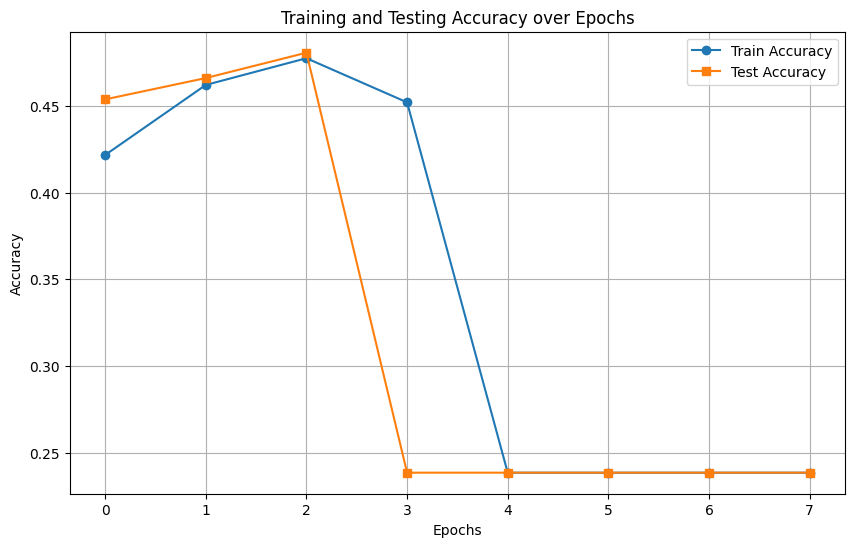

In [ ]:
import matplotlib.pyplot as plt

# 训练集的准确率列表
train_accuracy = acc_train

# 测试集的准确率列表
test_accuracy = acc_test

# 对应的epochs或时间步列表
epochs = range(len(acc_test))

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracy, marker='o', label='Train Accuracy')
plt.plot(epochs, test_accuracy, marker='s', label='Test Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
loss_range[-1900:]

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan

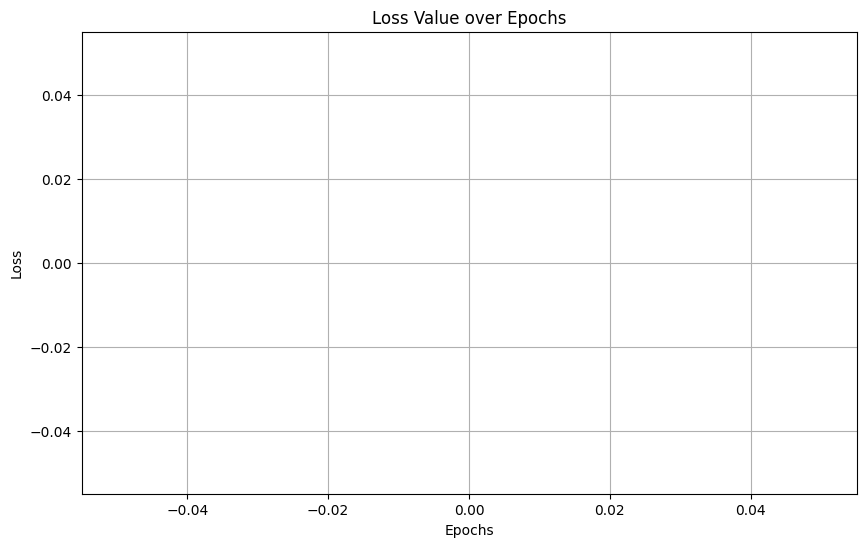

In [ ]:
import matplotlib.pyplot as plt

# 损失值列表
loss_values = loss_range[-1900:]

# 对应的epochs或时间步列表
epochs = range(len(loss_values))

plt.figure(figsize=(10, 6))
plt.plot(epochs, loss_values, color='r')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Value over Epochs')
plt.grid(True)
plt.show()

In [ ]:
print(label_need, label_pred)

In [ ]:
print(label_need_test)

In [ ]:
for epoc in range(40):
    label_need_train = []
    label_pred_train = []
    label_need = []
    label_pred = []
    i = 0
    loss_onebatch = 0
    x_train_fold = x_train_fold.sample(frac=1).reset_index(drop=True)
    data_reader = PandasDataReader(x_train_fold, batch_size=batch_size, shuffle=True)
    num_epochs = len(x_train_fold)
    for batch in data_reader:
        if False:
            loss = model([batch["mut0"]],[ batch["mut1"]], [batch["par0"]], [max(int(batch["Feature range(s)"][0].split("-")[0])-25,0),max(int(batch["Feature range(s)"][0].split("-")[0])-25,0)+50],class_weights,[batch["label"]],device) # 三个序列和需要的突变采样位置，如突变从80号开始就是[80-25，80+25]
            loss_onebatch = loss_onebatch + loss.item()
        else:
            positions = batch["position"].tolist()
            # print([sequence for sequence in batch["mut0"]][0])
            mut0,mut0_mask = esm_model.encode([sequence for sequence in batch["mut0"]])
            mut1,mut1_mask = esm_model.encode([sequence for sequence in batch["mut1"]])
            par0,par0_mask = esm_model.encode([sequence for sequence in batch["par0"]])
            #类似位置编码，标记突变前后的
            zero_row = torch.zeros(mut0.shape[0], mut0.shape[1], 1).to(device)
            mut0 = torch.cat((mut0, zero_row), dim=-1)
            zero_row = torch.ones(mut1.shape[0], mut1.shape[1], 1).to(device)
            mut1 = torch.cat((mut1, zero_row), dim=-1)
            #处理mut0，mut1，去除0，找到位置，接入全局变量，01拼接在模型里
            # mut0 = mut0[:, 1:, :]
            if mut0.shape[1] < 2*len_half_protein_used:
                mut0 = torch.cat((mut0.mean(dim=1, keepdim=True),mut0),dim=1)
                mut0_mask = mut0_mask
                mut1 = torch.cat((mut1.mean(dim=1, keepdim=True),mut1),dim=1)
                mut1_mask = mut1_mask
            else:
                result = torch.randn(mut0.shape[0],2*len_half_protein_used,mut0.shape[2])
                result_padding = (np.random.randint(0, 2, size=(mut0.shape[0], 2*len_half_protein_used)) == 1)

                for ia in range(len(positions)):
                    position = int(positions[ia])
                    if position - len_half_protein_used < 0 :
                        result[ia, :, :] = mut0[ia,:2 * len_half_protein_used,:]
                        result_padding[ia, :] = mut0_mask[ia,1:1+2 * len_half_protein_used].cpu()
                    elif position + len_half_protein_used > mut0.shape[1] - 1:
                        result[ia, :, :] = mut0[ia,-2 * len_half_protein_used:,:]
                        result_padding[ia, :] = mut0_mask[ia, -2 * len_half_protein_used].cpu()
                    else:
                        result[ia, :, :] = mut0[ia,position - len_half_protein_used:position + len_half_protein_used,:]
                        result_padding[ia, :] = mut0_mask[ia,1+ position - len_half_protein_used:1 + position + len_half_protein_used].cpu()

                mut0 = torch.cat((mut0.mean(dim=1, keepdim=True).cpu(), result),dim=1)
                mut0_mask = result_padding
                mut0_mask = np.concatenate([np.full((mut0_mask.shape[0], 1), False), mut0_mask], axis=1)
                
                
                
                result = torch.randn(mut1.shape[0],2*len_half_protein_used,mut1.shape[2])
                result_padding = (np.random.randint(0, 2, size=(mut1.shape[0], 2*len_half_protein_used)) == 1)
                for ia in range(len(positions)):
                    position = int(positions[ia])
                    if position - len_half_protein_used < 0 :
                        result[ia, :, :] = mut1[ia,:2 * len_half_protein_used,:]
                        result_padding[ia, :] = mut1_mask[ia,1:1+2 * len_half_protein_used].cpu()
                    elif position + len_half_protein_used > mut1.shape[1] - 1:
                        result[ia, :, :] = mut1[ia,-2 * len_half_protein_used : ,:]
                        result_padding[ia, :] = mut1_mask[ia, -2 * len_half_protein_used].cpu()
                    else:
                        # print(i)
                        result[ia, :, :] = mut1[ia,position - len_half_protein_used:position + len_half_protein_used,:]
                        result_padding[ia, :] = mut1_mask[ia,1+ position - len_half_protein_used:1 + position + len_half_protein_used].cpu()
                mut1 = torch.cat((mut1.mean(dim=1, keepdim=True).cpu(), result),dim=1)
                mut1_mask = result_padding
                mut1_mask = np.concatenate([np.full((mut1_mask.shape[0], 1), False), mut1_mask], axis=1)
                
                
            mut0_mask = torch.from_numpy(mut0_mask)
            mut0_mask = mut0_mask.to(device)
            mut1_mask = torch.from_numpy(mut1_mask)
            mut1_mask = mut1_mask.to(device)
            mut0 = mut0.to(device)
            mut1 = mut1.to(device)
            par0 = par0.to(device)
            # par0_mask = torch.from_numpy(par0_mask)
            # for position in batch["Feature range(s)"]:
            #     positions.append([max(int(position[0].split("-")[0])-25,0),max(int(position[0].split("-")[0])-25,0)+50])
            out = model(mut0, mut1, par0,mut0_mask,mut1_mask,par0_mask, class_weights,batch["label"])
            loss = model_loss(batch["label"], out,class_weights)
            _, predicted_labels = torch.max(out, 1)
            # break
            # loss = ghm_loss(out, batch["label"].to_list())
            # loss_onebatch = loss_onebatch + loss.item()
            loss_range.append(loss.item())
            # print(loss.item())
            
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        print("done")
        label_need_train = label_need_train + batch["label"].to_list()
        label_pred_train = label_pred_train + predicted_labels.tolist()
        if (i) % batch_size*20 == 0:
            clear_output()
            print(f' [{i}/{num_epochs}], Loss: {loss}')

        i = i+batch_size
    accuracy = accuracy_score(label_need_train,label_pred_train)
    acc_train.append(accuracy)
    torch.save(model.state_dict(), 'model_params_copy3.pth')
    model.eval()
    data_reader = PandasDataReader(x_test_fold, batch_size=10, shuffle=True)
    num_epochs = len(x_train_fold)
    print("testing",epoc)
    for batch in data_reader:
        if False:
            loss = model([batch["mut0"]],[ batch["mut1"]], [batch["par0"]], [max(int(batch["Feature range(s)"][0].split("-")[0])-25,0),max(int(batch["Feature range(s)"][0].split("-")[0])-25,0)+50],class_weights,[batch["label"]],device) # 三个序列和需要的突变采样位置，如突变从80号开始就是[80-25，80+25]
            loss_onebatch = loss_onebatch + loss.item()
        else:
            positions = batch["position"].tolist()
            # print([sequence for sequence in batch["mut0"]][0])
            mut0,mut0_mask = esm_model.encode([sequence for sequence in batch["mut0"]])
            mut1,mut1_mask = esm_model.encode([sequence for sequence in batch["mut1"]])
            par0,par0_mask = esm_model.encode([sequence for sequence in batch["par0"]])
            zero_row = torch.zeros(mut0.shape[0], mut0.shape[1], 1).to(device)
            mut0 = torch.cat((mut0, zero_row), dim=-1)
            zero_row = torch.ones(mut1.shape[0], mut1.shape[1], 1).to(device)
            mut1 = torch.cat((mut1, zero_row), dim=-1)
            #处理mut0，mut1，去除0，找到位置，接入全局变量，01拼接在模型里
            # mut0 = mut0[:, 1:, :]
            if mut0.shape[1] < 2*len_half_protein_used:
                mut0 = torch.cat((mut0.mean(dim=1, keepdim=True),mut0),dim=1)
                mut0_mask = mut0_mask
                mut1 = torch.cat((mut1.mean(dim=1, keepdim=True),mut1),dim=1)
                mut1_mask = mut1_mask
            else:
                result = torch.randn(mut0.shape[0],2*len_half_protein_used,mut0.shape[2])
                result_padding = (np.random.randint(0, 2, size=(mut0.shape[0], 2*len_half_protein_used)) == 1)

                for ia in range(len(positions)):
                    position = int(positions[ia])
                    if position - len_half_protein_used < 0 :
                        result[ia, :, :] = mut0[ia,:2 * len_half_protein_used,:]
                        result_padding[ia, :] = mut0_mask[ia,1:1+2 * len_half_protein_used].cpu()
                    elif position + len_half_protein_used > mut0.shape[1] - 1:
                        result[ia, :, :] = mut0[ia,-2 * len_half_protein_used:,:]
                        result_padding[ia, :] = mut0_mask[ia, -2 * len_half_protein_used].cpu()
                    else:
                        result[ia, :, :] = mut0[ia,position - len_half_protein_used:position + len_half_protein_used,:]
                        result_padding[ia, :] = mut0_mask[ia,1+ position - len_half_protein_used:1 + position + len_half_protein_used].cpu()

                mut0 = torch.cat((mut0.mean(dim=1, keepdim=True).cpu(), result),dim=1)
                mut0_mask = result_padding
                mut0_mask = np.concatenate([np.full((mut0_mask.shape[0], 1), False), mut0_mask], axis=1)
                
                
                
                result = torch.randn(mut1.shape[0],2*len_half_protein_used,mut1.shape[2])
                result_padding = (np.random.randint(0, 2, size=(mut1.shape[0], 2*len_half_protein_used)) == 1)
                for ia in range(len(positions)):
                    position = int(positions[ia])
                    if position - len_half_protein_used < 0 :
                        result[ia, :, :] = mut1[ia,:2 * len_half_protein_used,:]
                        result_padding[ia, :] = mut1_mask[ia,1:1+2 * len_half_protein_used].cpu()
                    elif position + len_half_protein_used > mut1.shape[1] - 1:
                        result[ia, :, :] = mut1[ia,-2 * len_half_protein_used : ,:]
                        result_padding[ia, :] = mut1_mask[ia, -2 * len_half_protein_used].cpu()
                    else:
                        # print(i)
                        result[ia, :, :] = mut1[ia,position - len_half_protein_used:position + len_half_protein_used,:]
                        result_padding[ia, :] = mut1_mask[ia,1+ position - len_half_protein_used:1 + position + len_half_protein_used].cpu()
                mut1 = torch.cat((mut1.mean(dim=1, keepdim=True).cpu(), result),dim=1)
                mut1_mask = result_padding
                mut1_mask = np.concatenate([np.full((mut1_mask.shape[0], 1), False), mut1_mask], axis=1)
                
                
            mut0_mask = torch.from_numpy(mut0_mask)
            mut0_mask = mut0_mask.to(device)
            mut1_mask = torch.from_numpy(mut1_mask)
            mut1_mask = mut1_mask.to(device)
            mut0 = mut0.to(device)
            mut1 = mut1.to(device)
            par0 = par0.to(device)
            x = model(mut0, mut1, par0, mut0_mask, mut1_mask, par0_mask, class_weights,batch["label"])
            _, predicted = torch.max(x, 1)
            label_pred = label_pred + predicted.tolist()
            label_need = label_need + batch['label'].to_list()
    accuracy = accuracy_score(label_need, label_pred)
    acc_test.append(accuracy)
    model.train()
    with open('test_result_copy3.json', 'w') as file:
        json.dump(acc_test, file)
    with open('train_result_copy3.json', 'w') as file:
        json.dump(acc_train, file)
    if accuracy > 0.8:
        break

TypeError: forward() missing 1 required positional argument: 'label'

In [ ]:
acc_train

[0.48628409872392453,
 0.5138305188354856,
 0.5331244746695194,
 0.5493237563994804,
 0.5608619240467639,
 0.5689997707648812,
 0.5754183540918468,
 0.5846259646977917,
 0.589439902193016,
 0.5960113089325285,
 0.6052953312447467,
 0.6082371819362726,
 0.6088102697333232,
 0.6125544433407198,
 0.6195079086115993,
 0.6211507602964774,
 0.6237105524566363,
 0.55639183922977,
 0.569916711240162,
 0.5816841140062657,
 0.5905478719339803,
 0.5988385420646443,
 0.6060594483074807,
 0.6070528004890349,
 0.6154198823259723,
 0.6173301749828074,
 0.6209215251776572,
 0.6253534041415145,
 0.629747077252235,
 0.6320776342935738,
 0.6333766333002216,
 0.637541071292122,
 0.6381141590891725,
 0.6420875678153893,
 0.6455260945976924,
 0.6393749522426836,
 0.6481622984641247,
 0.6531672652250324,
 0.6562619393291053,
 0.6551157637350042,
 0.659089172461221,
 0.6793764804768091,
 0.7013448460304118,
 0.7086803698326584,
 0.7199510965079851,
 0.7296553832047069,
 0.7376022006571407,
 0.749675250248338,

In [ ]:
model.eval()

In [ ]:
import sys
def print_progress_bar(iteration, total, length=40):
    percent = (iteration / total) * 100
    filled_length = int(length * iteration // total)
    bar = '█' * filled_length + '-' * (length - filled_length)
    sys.stdout.write(f'\r|{bar}| {percent:.2f}% Complete')
    sys.stdout.flush()

In [ ]:
model.eval()
data_reader = PandasDataReader(x_test_fold, batch_size=10, shuffle=True)
num_epochs = len(x_train_fold)
print("testing",epoc)
for batch in data_reader:
    if False:
        loss = model([batch["mut0"]],[ batch["mut1"]], [batch["par0"]], [max(int(batch["Feature range(s)"][0].split("-")[0])-25,0),max(int(batch["Feature range(s)"][0].split("-")[0])-25,0)+50],class_weights,[batch["label"]],device) # 三个序列和需要的突变采样位置，如突变从80号开始就是[80-25，80+25]
        loss_onebatch = loss_onebatch + loss.item()
    else:
        positions = batch["position"].tolist()
        # print([sequence for sequence in batch["mut0"]][0])
        mut0,mut0_mask = esm_model.encode([sequence for sequence in batch["mut0"]])
        mut1,mut1_mask = esm_model.encode([sequence for sequence in batch["mut1"]])
        par0,par0_mask = esm_model.encode([sequence for sequence in batch["par0"]])
        # zero_row = torch.zeros(mut0.shape[0], mut0.shape[1], 1).to(device)
        # mut0 = torch.cat((mut0, zero_row), dim=-1)
        # zero_row = torch.ones(mut1.shape[0], mut1.shape[1], 1).to(device)
        # mut1 = torch.cat((mut1, zero_row), dim=-1)
        #处理mut0，mut1，去除0，找到位置，接入全局变量，01拼接在模型里
        # mut0 = mut0[:, 1:, :]
        if mut0.shape[1] < 2*len_half_protein_used:
            mut0 = torch.cat((mut0.mean(dim=1, keepdim=True),mut0),dim=1)
            mut0_mask = mut0_mask
            mut1 = torch.cat((mut1.mean(dim=1, keepdim=True),mut1),dim=1)
            mut1_mask = mut1_mask
        else:
            result = torch.randn(mut0.shape[0],2*len_half_protein_used,mut0.shape[2])
            result_padding = (np.random.randint(0, 2, size=(mut0.shape[0], 2*len_half_protein_used)) == 1)

            for ia in range(len(positions)):
                position = int(positions[ia])
                if position - len_half_protein_used < 0 :
                    result[ia, :, :] = mut0[ia,:2 * len_half_protein_used,:]
                    result_padding[ia, :] = mut0_mask[ia, : 2 * len_half_protein_used].cpu()
                elif position + len_half_protein_used > mut0.shape[1] :
                    result[ia, :, :] = mut0[ia,-2 * len_half_protein_used:,:]
                    result_padding[ia, :] = mut0_mask[ia, -2 * len_half_protein_used].cpu()
                else:
                    result[ia, :, :] = mut0[ia,position - len_half_protein_used:position + len_half_protein_used,:]
                    result_padding[ia, :] = mut0_mask[ia, position - len_half_protein_used : position + len_half_protein_used].cpu()

            mut0 = torch.cat((mut0.mean(dim=1, keepdim=True).cpu(), result),dim=1)
            mut0_mask = result_padding
            mut0_mask = np.concatenate([np.full((mut0_mask.shape[0], 1), False), mut0_mask], axis=1)
            
            
            
            result = torch.randn(mut1.shape[0],2*len_half_protein_used,mut1.shape[2])
            result_padding = (np.random.randint(0, 2, size=(mut1.shape[0], 2*len_half_protein_used)) == 1)
            for ia in range(len(positions)):
                position = int(positions[ia])
                if position - len_half_protein_used < 0 :
                    result[ia, :, :] = mut1[ia,:2 * len_half_protein_used,:]
                    result_padding[ia, :] = mut1_mask[ia , : 2 * len_half_protein_used].cpu()
                elif position + len_half_protein_used > mut1.shape[1] :
                    result[ia, :, :] = mut1[ia,-2 * len_half_protein_used : ,:]
                    result_padding[ia, :] = mut1_mask[ia , -2 * len_half_protein_used].cpu()
                else:
                    # print(i)
                    result[ia, :, :] = mut1[ia,position - len_half_protein_used:position + len_half_protein_used,:]
                    result_padding[ia, :] = mut1_mask[ia, position - len_half_protein_used : position + len_half_protein_used].cpu()
            mut1 = torch.cat((mut1.mean(dim=1, keepdim=True).cpu(), result),dim=1)
            mut1_mask = result_padding
            mut1_mask = np.concatenate([np.full((mut1_mask.shape[0], 1), False), mut1_mask], axis=1)
            
            
        mut0_mask = torch.from_numpy(mut0_mask)
        mut0_mask = mut0_mask.to(device)
        mut1_mask = torch.from_numpy(mut1_mask)
        mut1_mask = mut1_mask.to(device)
        mut0 = mut0.to(device)
        mut1 = mut1.to(device)
        par0 = par0.to(device)
        mut0 = mut0 + position_embedding[:mut0.shape[1] , : ]
        mut1 = mut1 + position_embedding[2 * len_half_protein_used + 1 : 2 * len_half_protein_used + 1 + mut1.shape[1] , : ]
        x = model(mut0, mut1, par0, mut0_mask,mut1_mask, par0_mask, class_weights,batch["label"])
        _, predicted = torch.max(x, 1)
        label_pred = label_pred + predicted.tolist()
        label_need = label_need + batch['label'].to_list()
# accuracy = accuracy_score(label_need, label_pred)
# acc_test.append(accuracy)
# model.train()
    print_progress_bar(len(label_need), x_test_fold.shape[0], length=40)

testing 0


|████████████████████████████████████████| 100.00% Complete

In [ ]:
from sklearn.metrics import classification_report
report_df = classification_report(label_need, label_pred, target_names=['Disrupting', 'Decreasing', 'No effect', 'Increasing'], output_dict=True)
report_df = pd.DataFrame(report_df).transpose()

# 设置小数位数
pd.set_option('display.float_format', '{:.4f}'.format)

# 打印格式化后的报告
print(report_df)

              precision  recall  f1-score   support
Disrupting       0.6536  0.6803    0.6667  635.0000
Decreasing       0.5160  0.3899    0.4442  495.0000
No effect        0.8661  0.9127    0.8888 1283.0000
Increasing       0.5854  0.6162    0.6004  495.0000
accuracy         0.7225  0.7225    0.7225    0.7225
macro avg        0.6553  0.6498    0.6500 2908.0000
weighted avg     0.7123  0.7225    0.7155 2908.0000


In [ ]:
torch.save(model.state_dict(), 'model_params_withoutcross.pth')

In [ ]:
torch.save(model.state_dict(), 'model_params_copy3.pth')

In [ ]:
with open('label_need_withoutcross.json', 'w') as file:
    json.dump(label_need, file)
with open('label_pred_withoutcross.json', 'w') as file:
    json.dump(label_pred, file)